
### Jupyter Notebook
##  **Learning to steer: a Trajectory Prediction model from Flight Plans**

<br>
<br>
by
<b>Gabriel Mesquida Masana</b><br>
<a href=mailto:gabmm@stanford.edu>gabmm@stanford.edu</a>
<br>

In [4]:
from scene import Scene
from flight import Flight as Fl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import datetime
import math
import pickle
import random

In [4]:
# More output formatting
matplotlib.style.use("seaborn-v0_8-pastel")
pd.options.display.float_format = "{:,.2f}".format
sns.set_style("whitegrid")

# Note this configuration for retina screens only
%config InlineBackend.figure_format = 'retina'

# Only if you're editing the extensions
%load_ext autoreload
%autoreload 2

## Data from May 24

In [5]:
# Full data May 24
file_name = "24-05_full_exp.pkl"

In [6]:
scene1 = Scene(from_file=file_name)
scene1

Loaded 49884 flights


Scene with 49884 flights, loaded from 24-05_full_exp.pkl.

In [7]:
# Removing some rogue flights that seem to shoot to the moon

# May
if file_name == "24-05_full_exp.pkl":
    scene1.remove(
        [
            "13/05/2024-19:40 AWQ261 WSSS WIII A320",
            "30/05/2024-11:35 AXM140 WMKK ZGOW A320",
            "11/05/2024-10:51 VOZ9943 YPPH WSSL B738",
            "30/05/2024-20:02 SIA297 WSSS NZCH A359",
            "31/05/2024-07:09 SIA934 WSSS WADD B78X",
            "31/05/2024-13:43 AXM278 WMKK WBSB A320",
        ]
    )

Removed 11/05/2024-10:51 VOZ9943 YPPH WSSL B738
Removed 13/05/2024-19:40 AWQ261 WSSS WIII A320
Removed 30/05/2024-11:35 AXM140 WMKK ZGOW A320
Removed 30/05/2024-20:02 SIA297 WSSS NZCH A359
Removed 31/05/2024-07:09 SIA934 WSSS WADD B78X
Removed 31/05/2024-13:43 AXM278 WMKK WBSB A320


In [8]:
# Removing some flights which FPL doesn't match the Trk

# May
if file_name == "24-05_full_exp.pkl":
    scene1.remove(
        [
            "01/05/2024-12:03 AXM6414 WMKJ WMKP A320",
            "04/05/2024-07:18 AXM6412 WMKJ WMKP A320",
            "05/05/2024-22:06 AXM6422 WMKJ WMKP A320",
            "06/05/2024-07:08 AXM6412 WMKJ WMKP A320",
            "08/05/2024-11:45 AXM6043 WMKJ WMKK A320",
            "10/05/2024-07:57 AXM5135 WBKK WMKK A320",
            "11/05/2024-07:15 AXM6412 WMKJ WMKP A320",
            "11/05/2024-13:46 AXM6035 WMKJ WMKK A320",
            "12/05/2024-07:13 AXM6047 WMKJ WMKK A320",
            "13/05/2024-15:30 AXM6454 WMKJ WMKL A320",
            "16/05/2024-07:09 AXM6412 WMKJ WMKP A320",
            "17/05/2024-07:12 AXM6412 WMKJ WMKP A320",
            "17/05/2024-20:58 AXM6422 WMKJ WMKP A320",
            "25/05/2024-06:42 AXM6412 WMKJ WMKP A320",
            "27/05/2024-08:20 AXM6082 WMKJ WMKI A320",
            "28/05/2024-10:55 AWQ551 WMKK WADD A320",
            "29/05/2024-12:16 AXM6414 WMKJ WMKP A320",
            "29/05/2024-15:46 AXM6454 WMKJ WMKL A320",
        ]
    )

Removed 01/05/2024-12:03 AXM6414 WMKJ WMKP A320
Removed 04/05/2024-07:18 AXM6412 WMKJ WMKP A320
Removed 05/05/2024-22:06 AXM6422 WMKJ WMKP A320
Removed 06/05/2024-07:08 AXM6412 WMKJ WMKP A320
Removed 08/05/2024-11:45 AXM6043 WMKJ WMKK A320
Removed 10/05/2024-07:57 AXM5135 WBKK WMKK A320
Removed 11/05/2024-07:15 AXM6412 WMKJ WMKP A320
Removed 11/05/2024-13:46 AXM6035 WMKJ WMKK A320
Removed 12/05/2024-07:13 AXM6047 WMKJ WMKK A320
Removed 13/05/2024-15:30 AXM6454 WMKJ WMKL A320
Removed 16/05/2024-07:09 AXM6412 WMKJ WMKP A320
Removed 17/05/2024-07:12 AXM6412 WMKJ WMKP A320
Removed 17/05/2024-20:58 AXM6422 WMKJ WMKP A320
Removed 25/05/2024-06:42 AXM6412 WMKJ WMKP A320
Removed 27/05/2024-08:20 AXM6082 WMKJ WMKI A320
Removed 28/05/2024-10:55 AWQ551 WMKK WADD A320
Removed 29/05/2024-12:16 AXM6414 WMKJ WMKP A320
Removed 29/05/2024-15:46 AXM6454 WMKJ WMKL A320


## Overflights and Airbus 320

In [9]:
scene2 = Scene(from_scene=scene1).overflights().aircraft(aircraft="A320")
scene2

Scene with 7456 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320.

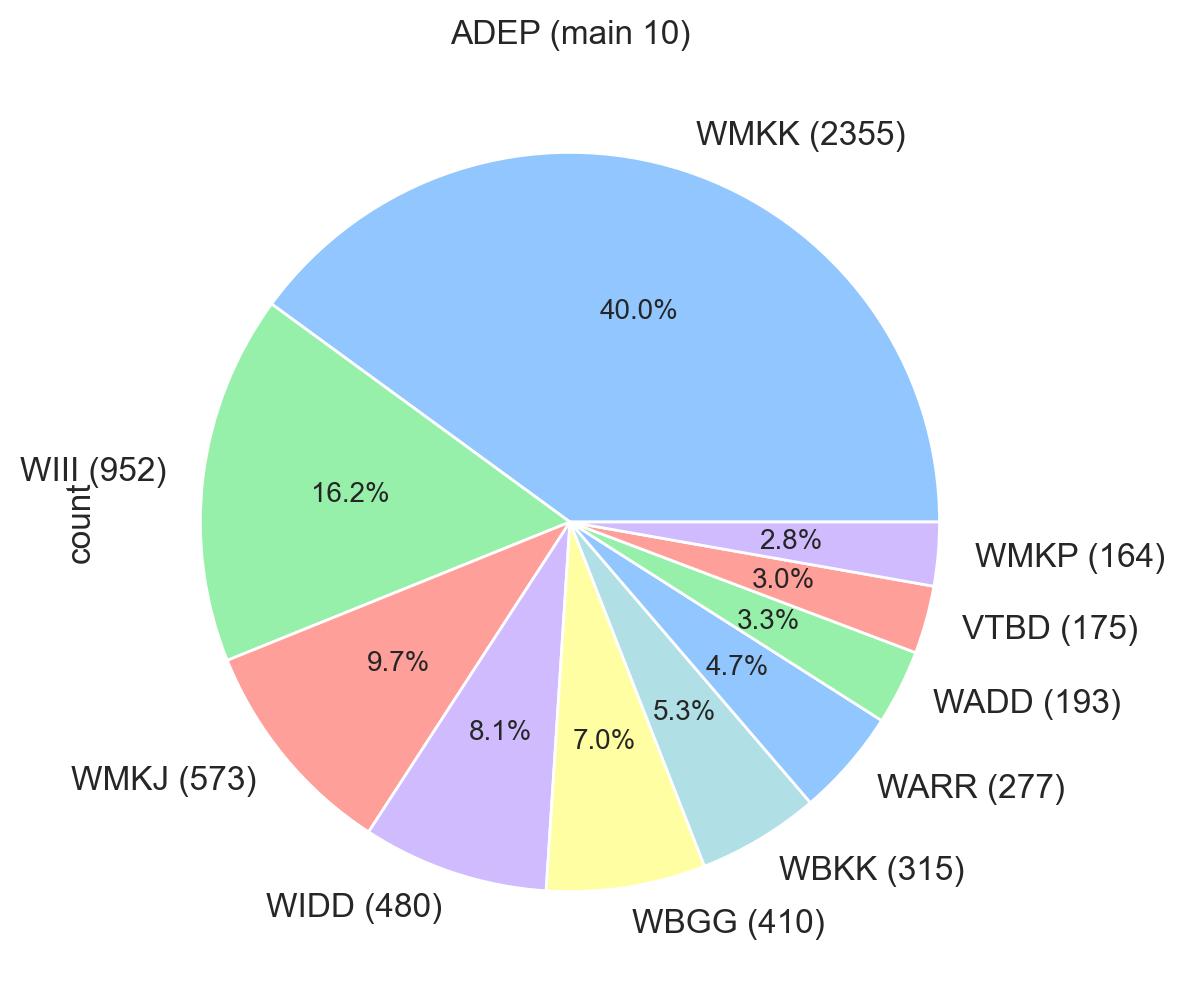

In [10]:
scene2.query_attribute(attribute="ADEP", pie=True)

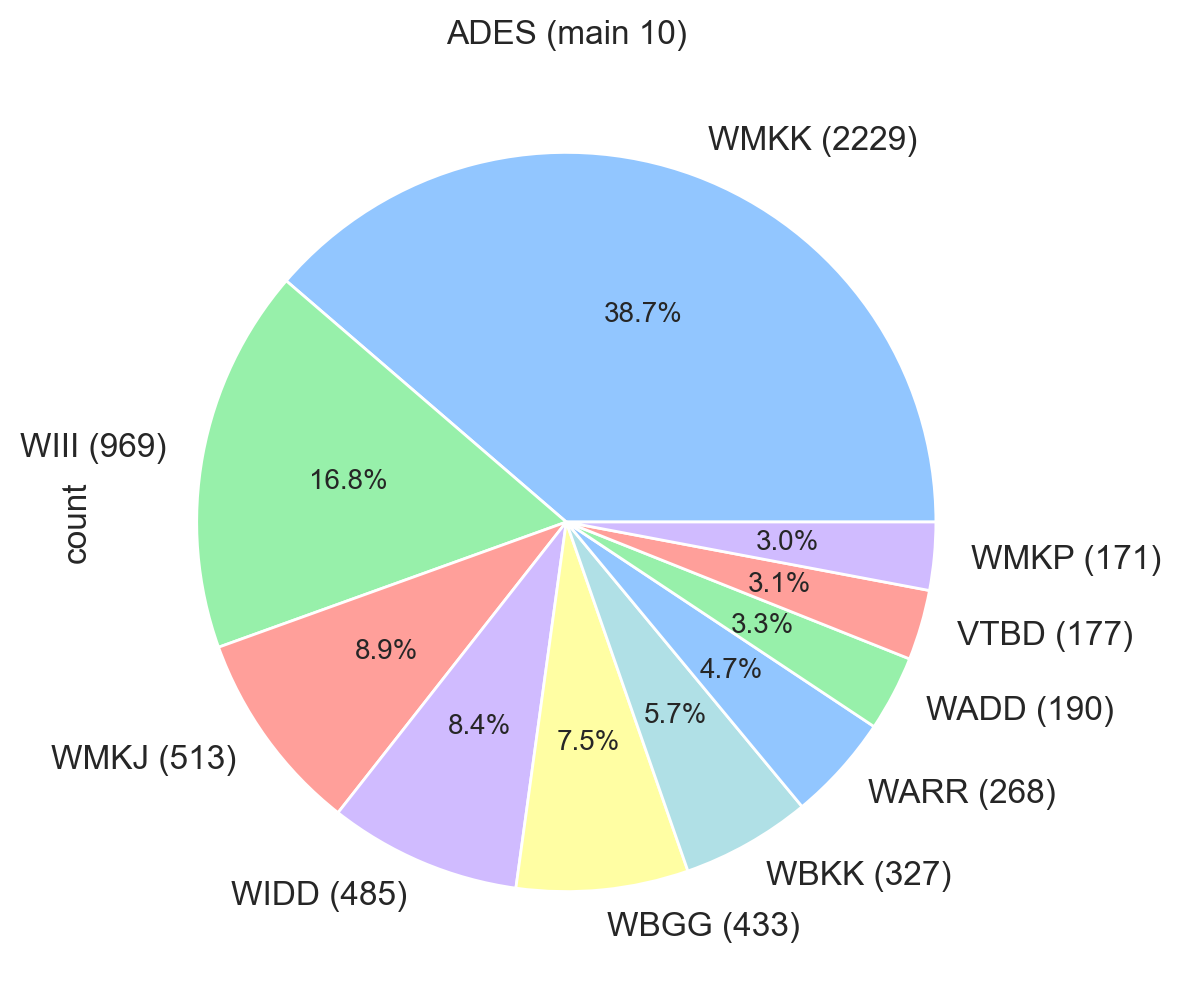

In [11]:
scene2.query_attribute(attribute="ADES", pie=True)

## Make sure FPL and Tracks are consistent

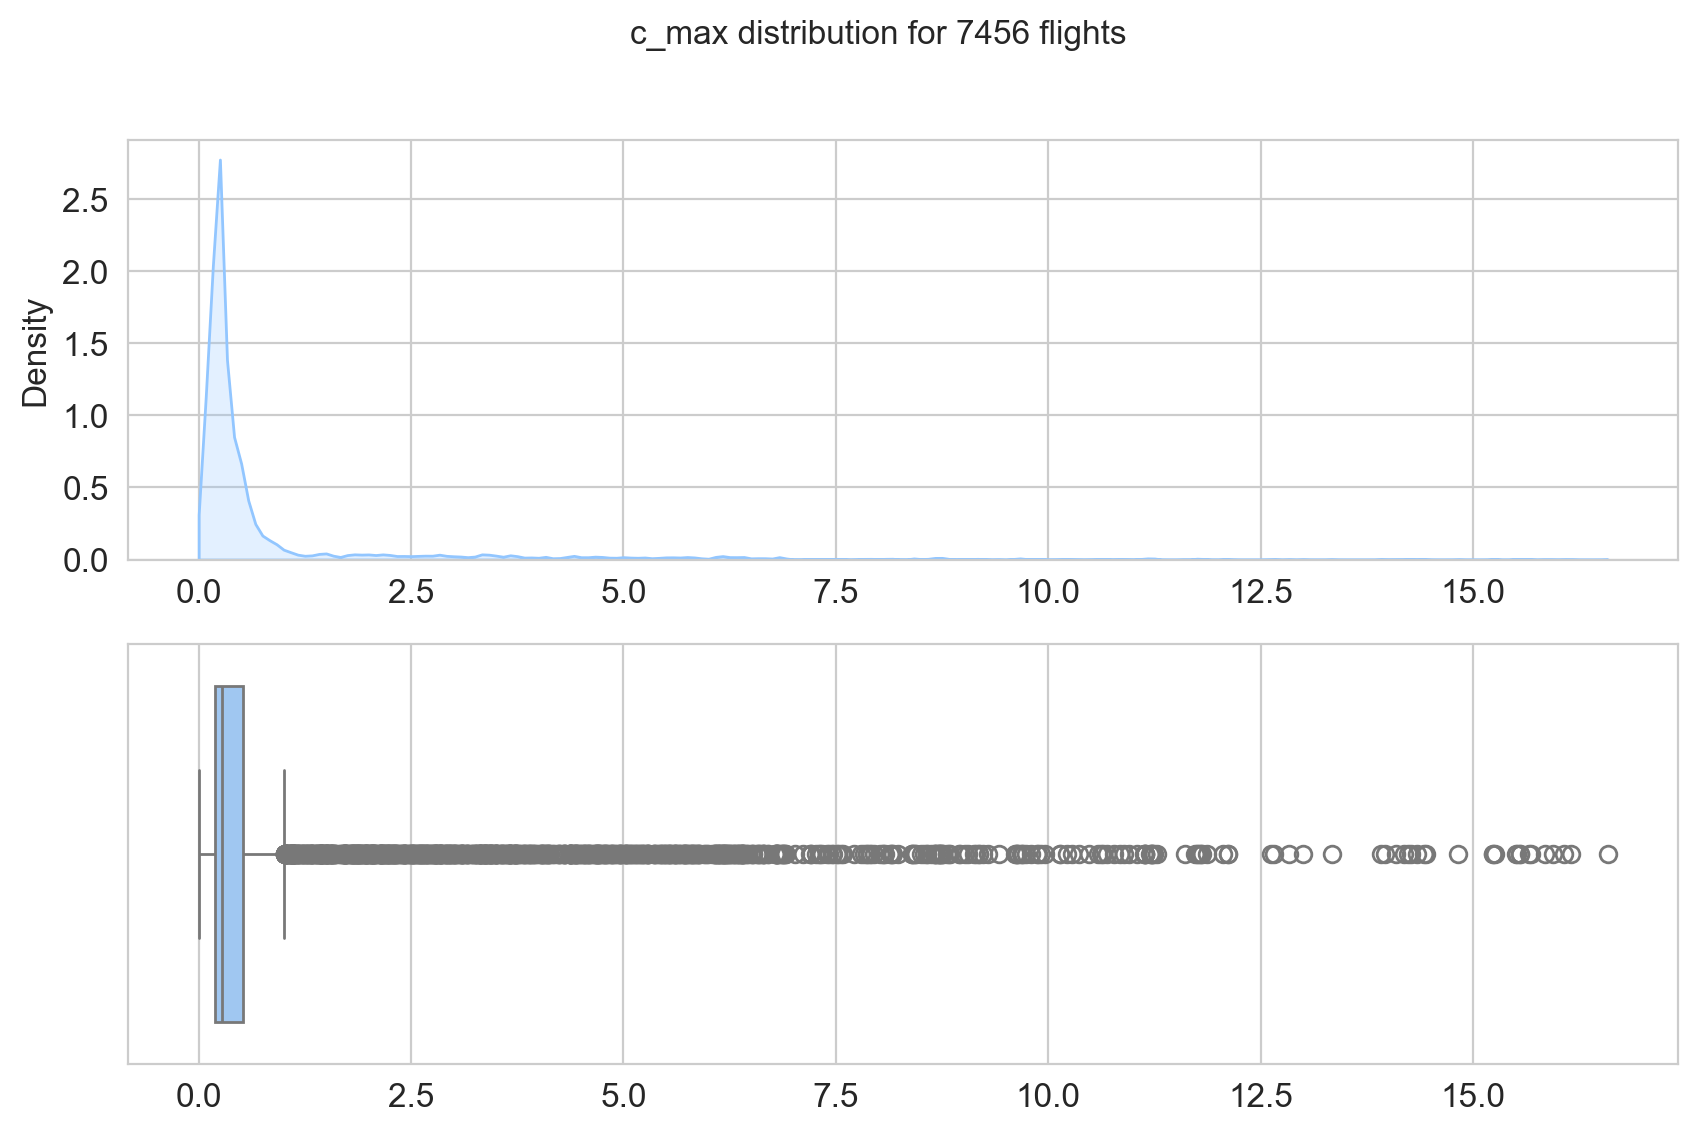

In [12]:
scene2.plot_c()

In [13]:
scene3, _ = scene2.split_c(c_threshold=1)
scene3

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1.

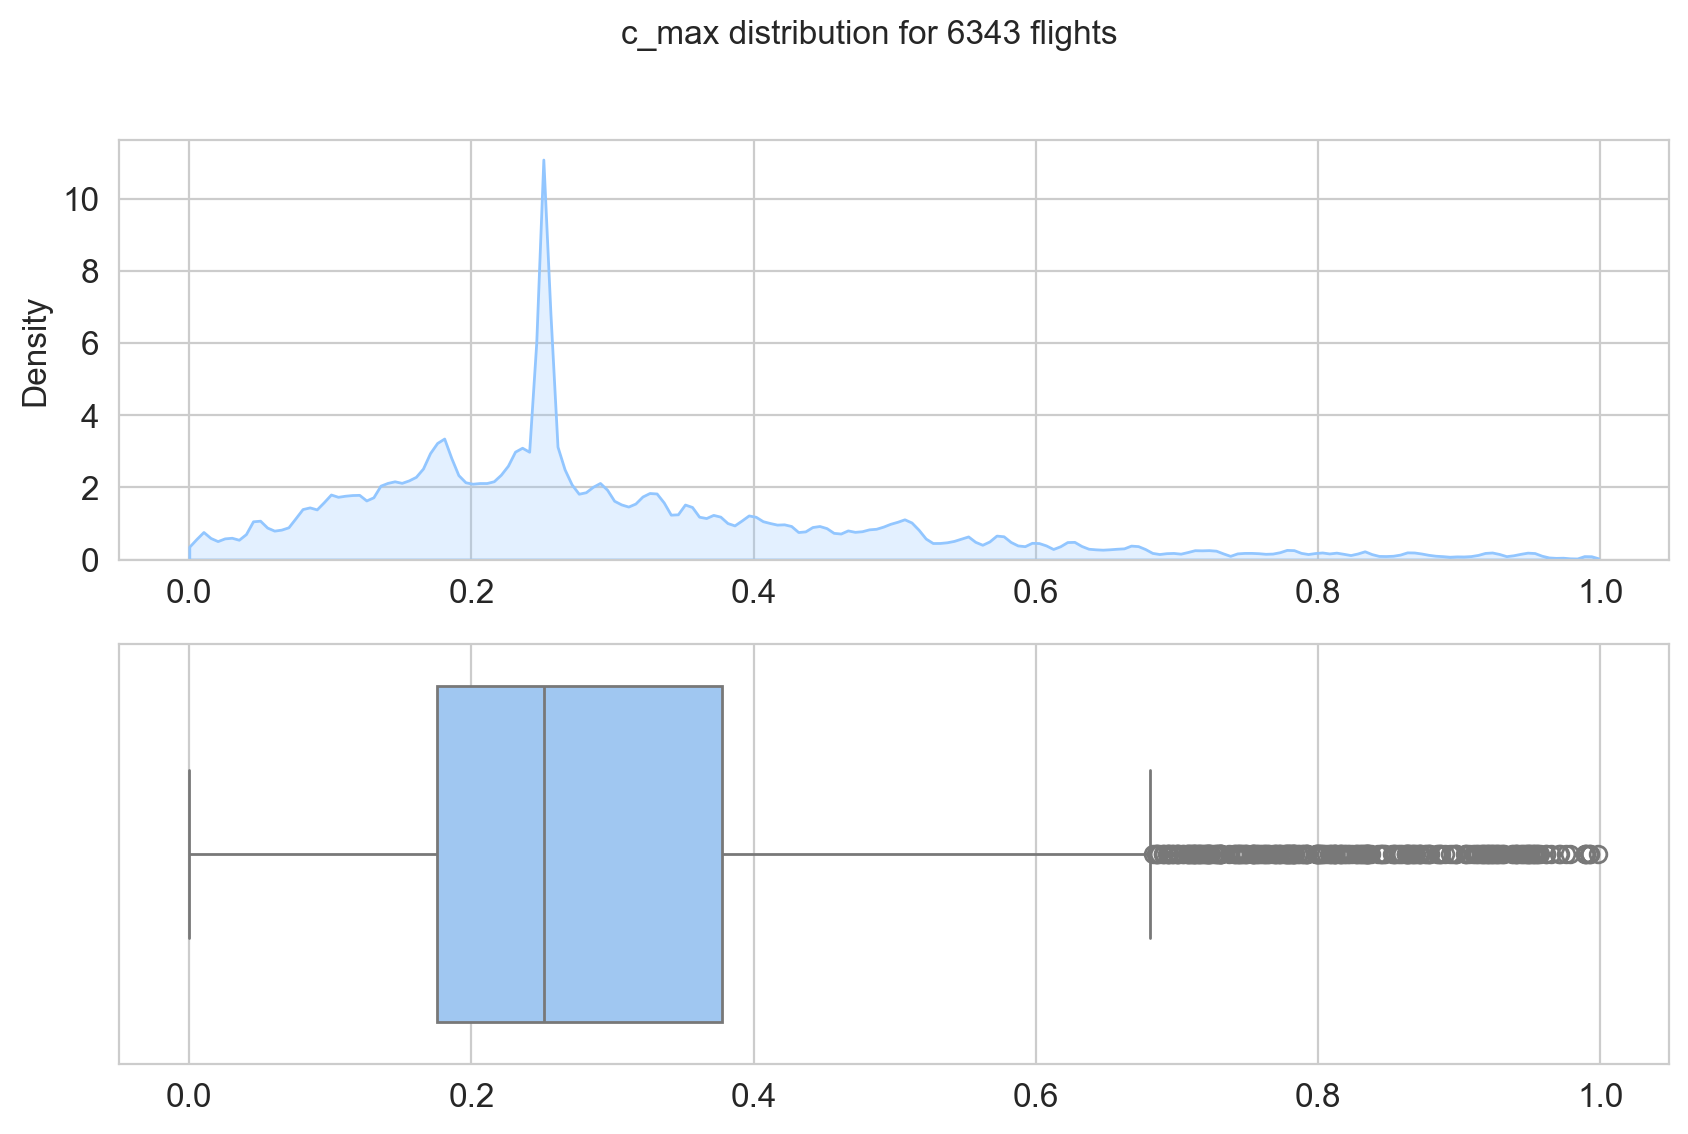

In [14]:
scene3.plot_c()

## Downsampling flights

* Down to every 20 seconds

In [15]:
scene3.downsample(factor=5)
scene3.flights[0].additional["time_gap"]

# see below for new sampling period

20

* Take a look at the elevation profiles. We could just select the cruise phase and have more clean data as an improvement idea.

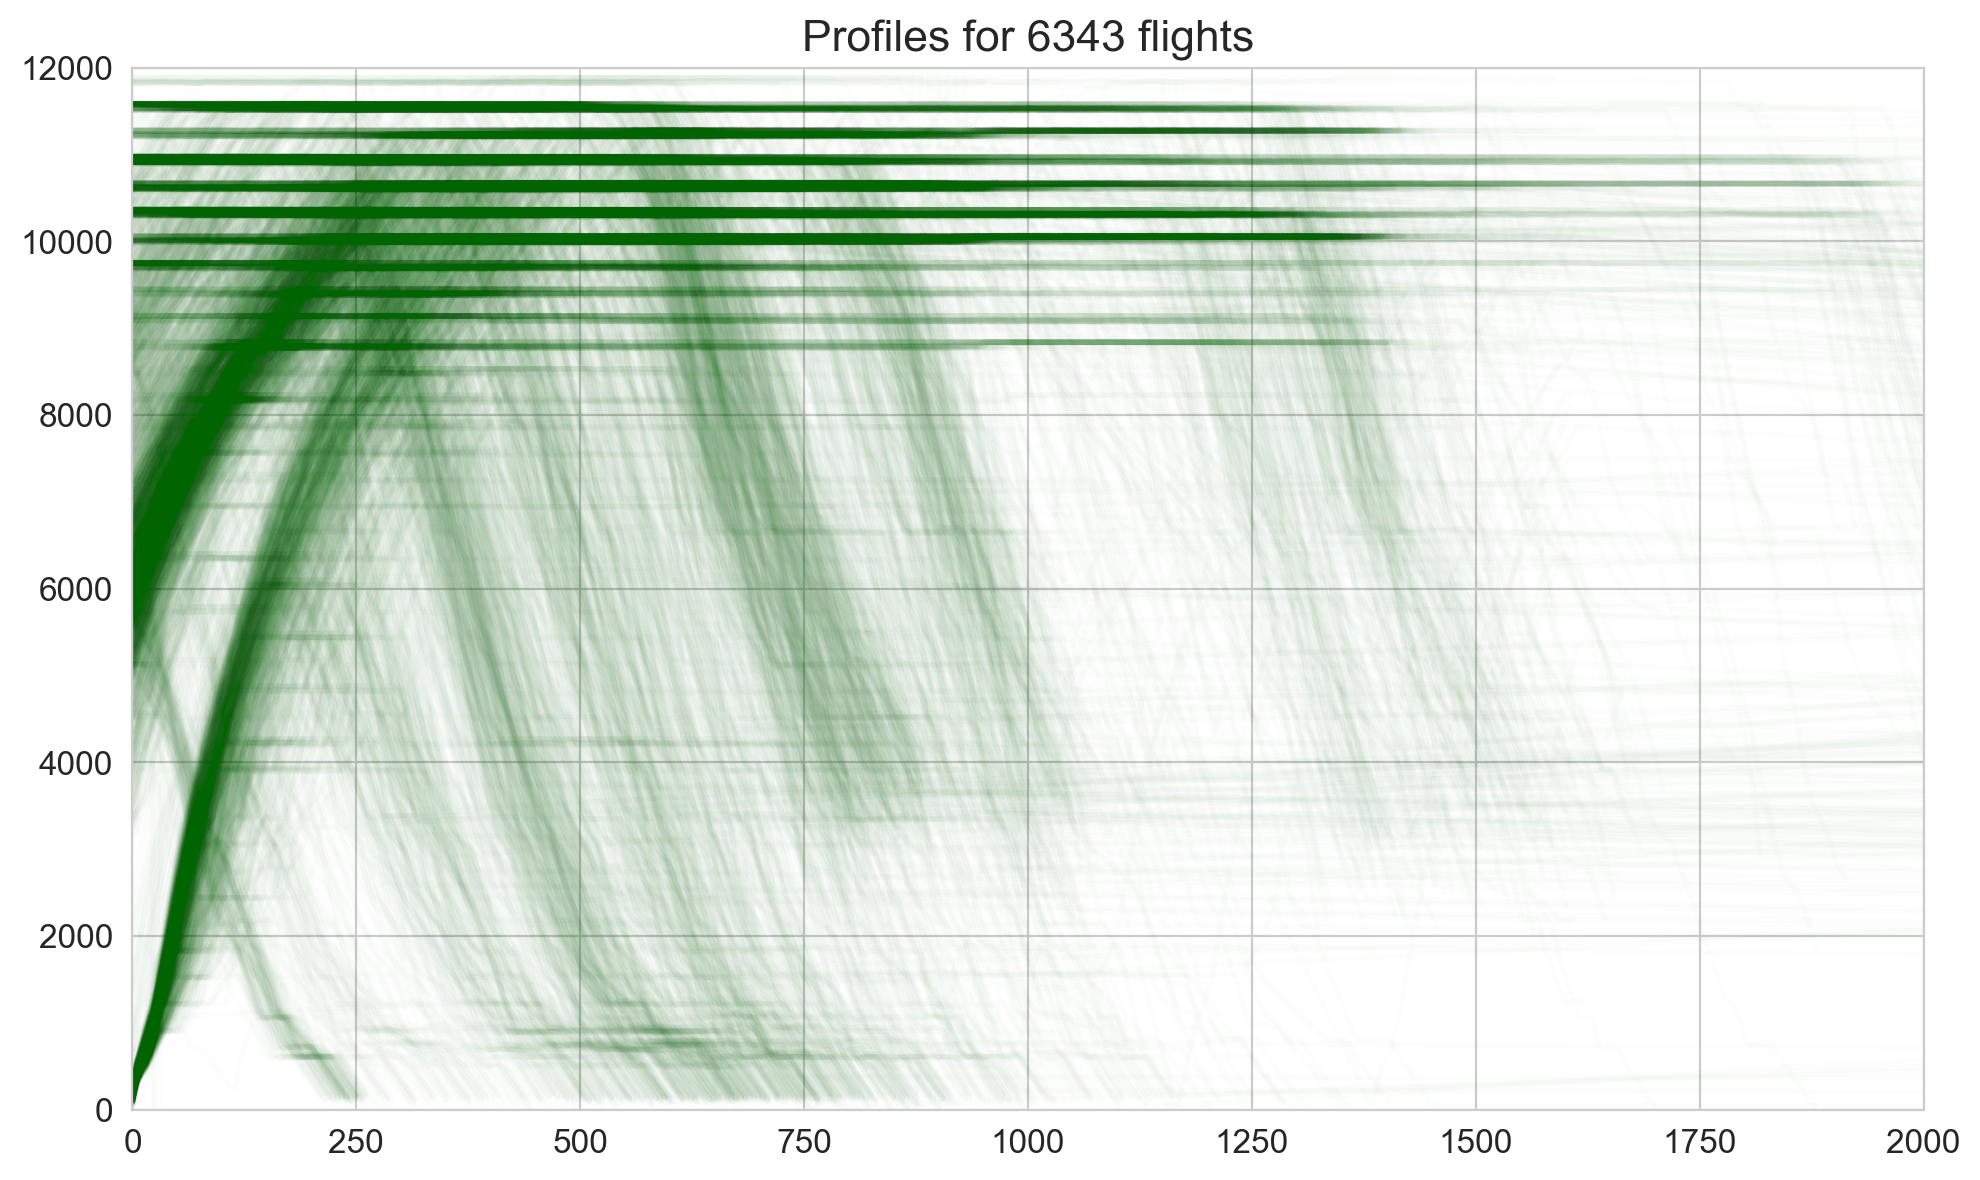

In [16]:
scene3.plot_elevation_profile(
    endalign=False, xlim=2000, ylim=(0, 12000), alpha=0.01
)

## Creating projections

In [17]:
scene3.project()

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection.

### Matching projection with tracks

In [20]:
scene3.match_project()

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left.

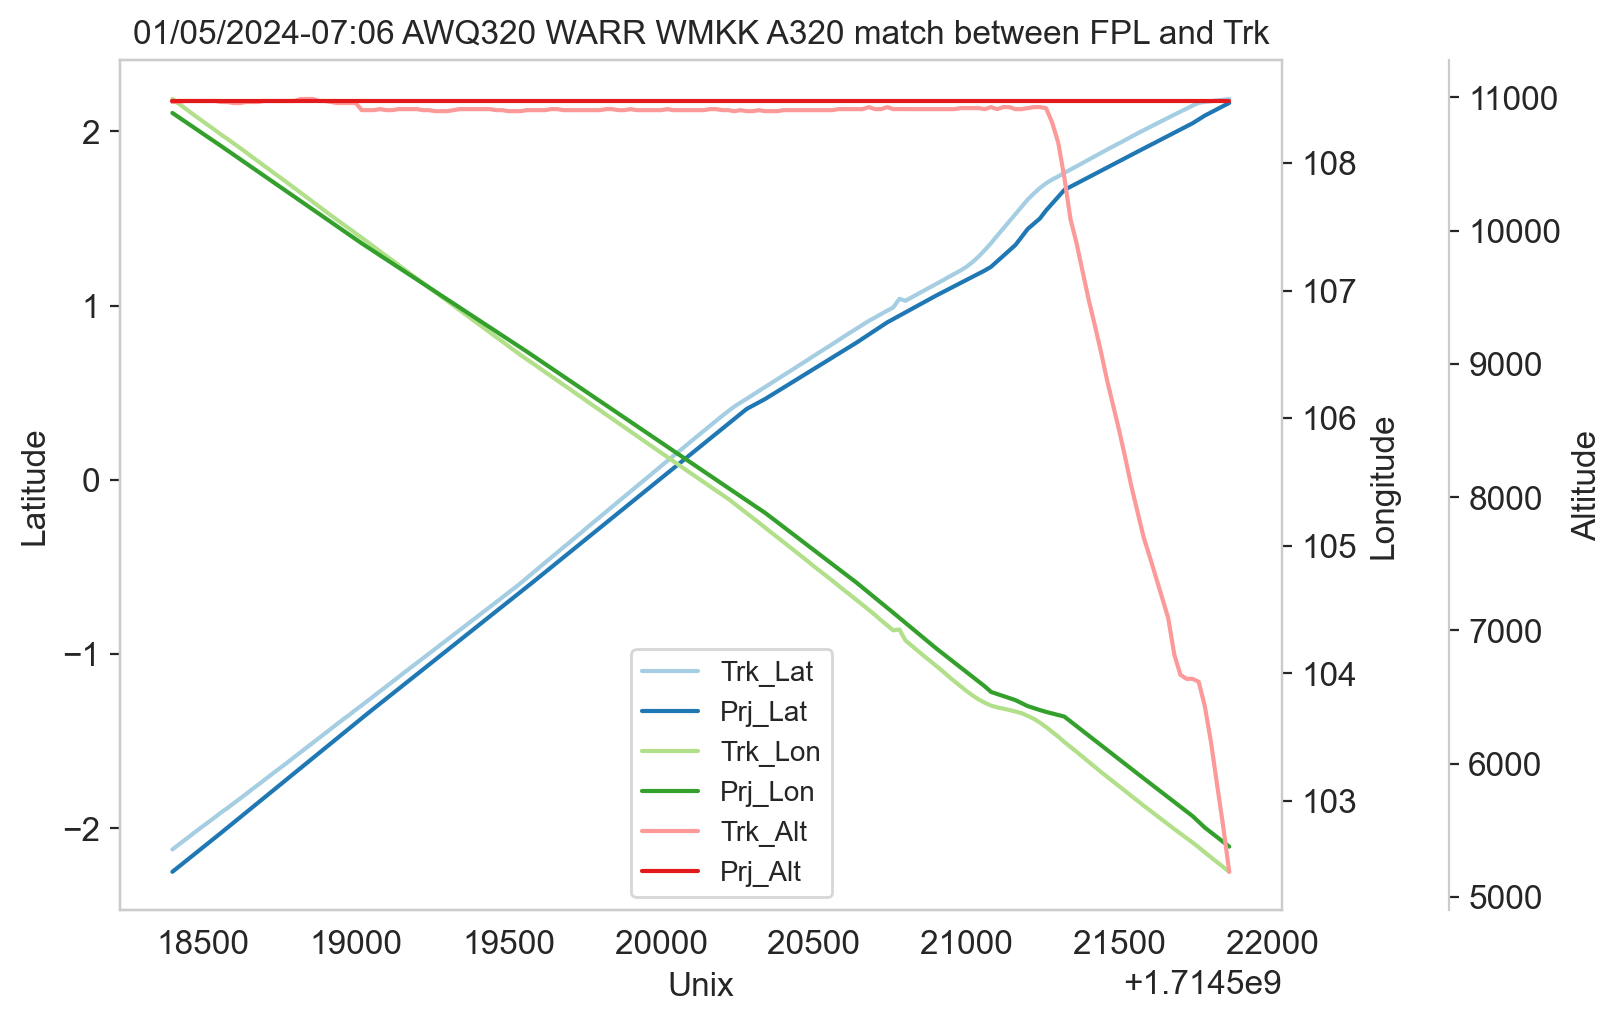

In [21]:
scene3.flights[1].plot_match(geo=True)

### Changing geodesic coordinates to ENU

In [23]:
scene3.match_convert_geo_to_enu()

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU.

See how the curvature of the planet now appears below:

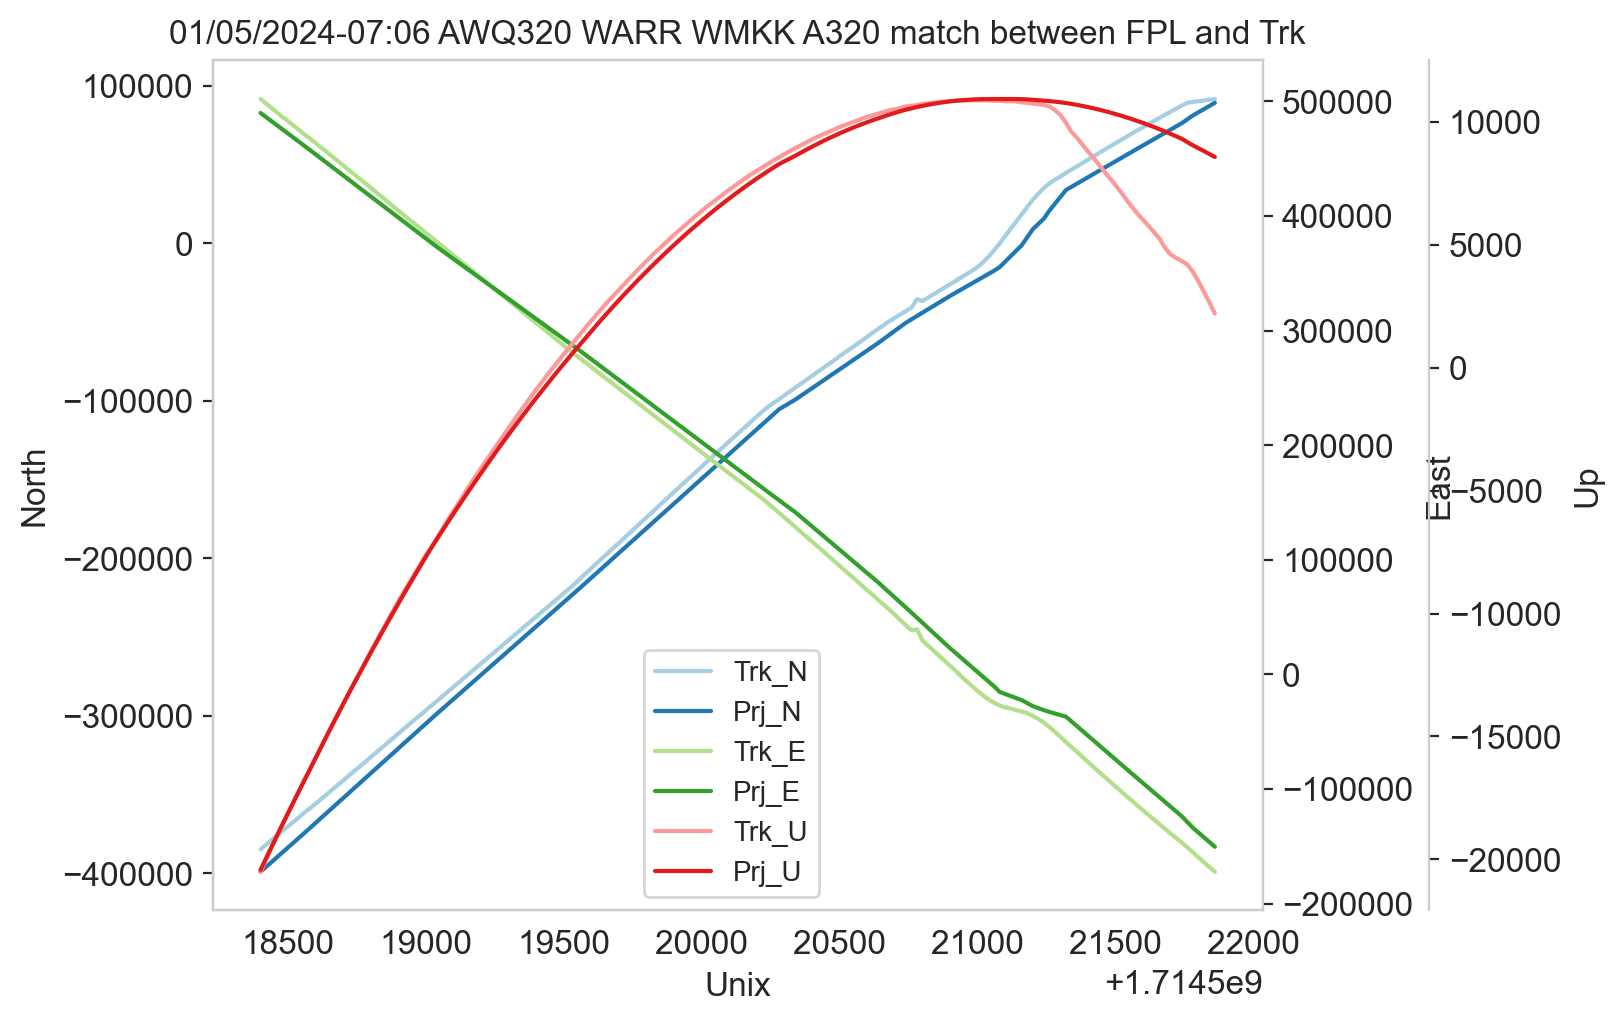

In [24]:
scene3.flights[1].plot_match(geo=False)

### Standardisation of position data

In [26]:
scene3.match_standardise_enu()
TRANSFORMATION = scene3.match_transform
TRANSFORMATION

{'e_max': 1517300.8775228173,
 'e_min': -489316.4886358802,
 'n_max': 1256678.2131043493,
 'n_min': -539681.7837180963,
 'u_max': 18987.70587689134,
 'u_min': -284450.3060762797}

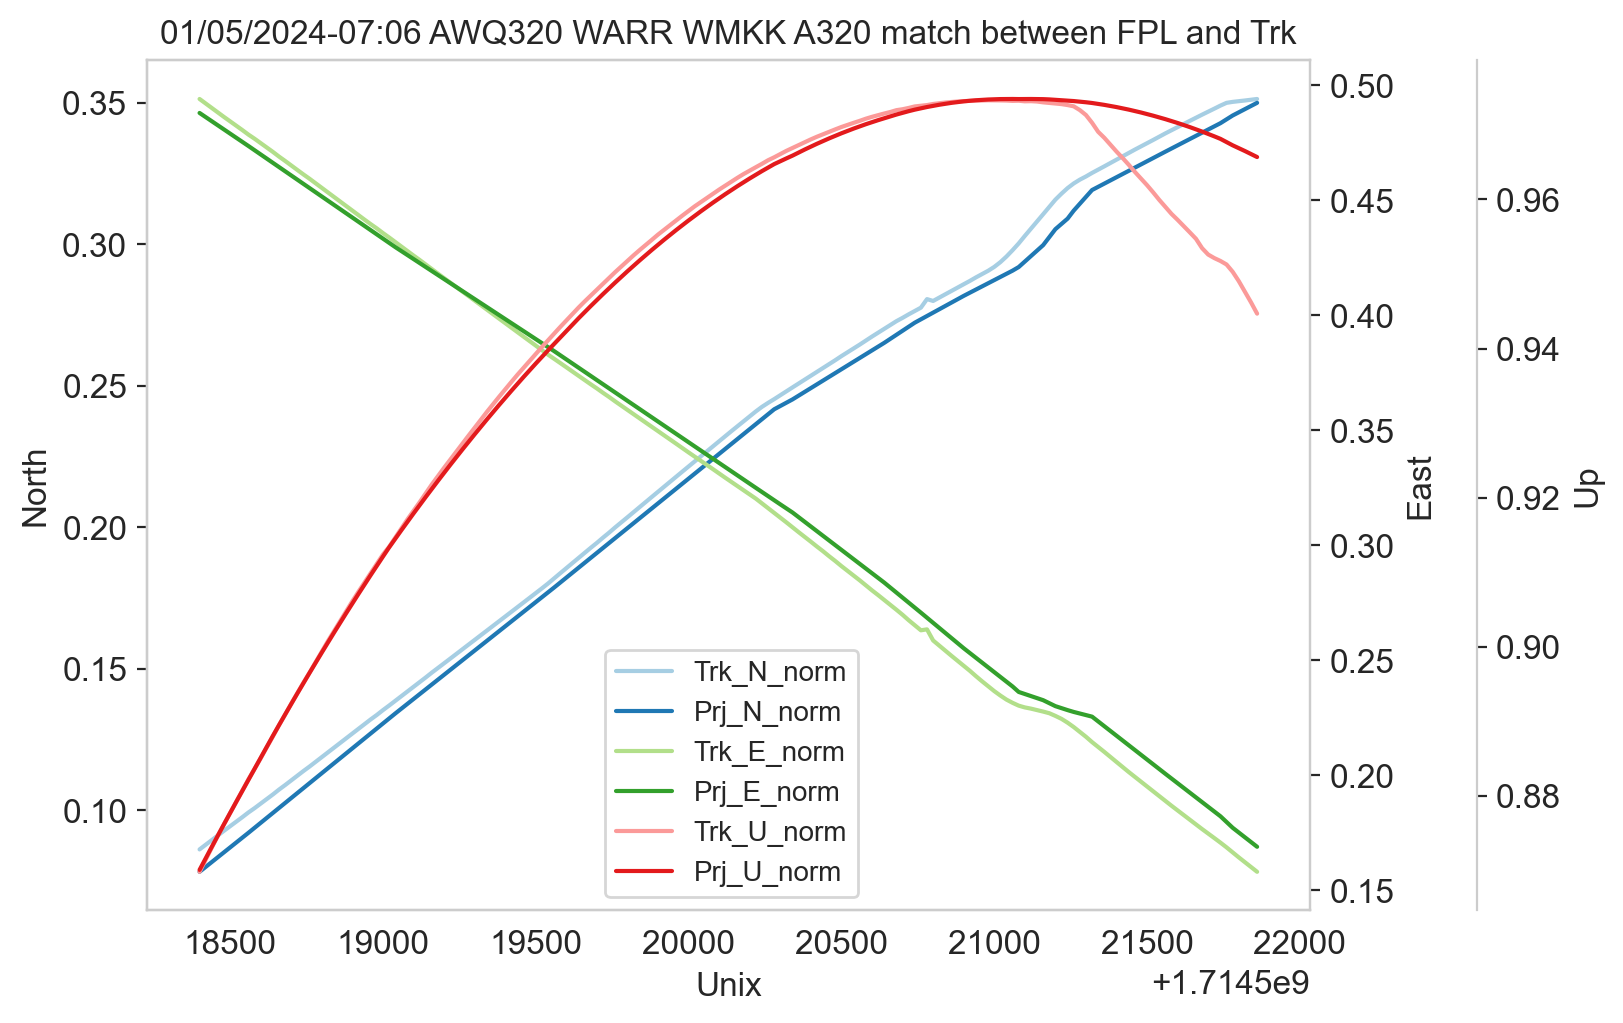

In [27]:
scene3.flights[1].plot_match(geo=False, norm=True)

In [28]:
SAVE_STANDARDISATION = False

if SAVE_STANDARDISATION:
    with open("logs/over_a320_std.pickle", "wb") as handle:
        pickle.dump(
            scene3.match_norm, handle, protocol=pickle.HIGHEST_PROTOCOL
        )

* Dataframe created

In [29]:
scene3.flights[1].match

Unix  Trk_Lat  Trk_Lon   Trk_Alt  Trk_Vx  Trk_Vy  Prj_Lat  Prj_Lon  \
0    1714518400    -2.12   108.50 10,965.18 -180.75  139.50    -2.25   108.39   
1    1714518420    -2.09   108.47 10,965.18 -187.50  143.00    -2.22   108.36   
2    1714518440    -2.07   108.43 10,972.80 -192.75  145.00    -2.19   108.33   
3    1714518460    -2.04   108.39 10,972.80 -199.25  150.50    -2.17   108.29   
4    1714518480    -2.01   108.36 10,972.80 -192.50  145.50    -2.14   108.26   
..          ...      ...      ...       ...     ...     ...      ...      ...   
169  1714521780     2.17   102.60  6,431.28 -218.50   33.50     2.09   102.79   
170  1714521800     2.17   102.56  6,164.58 -217.75   24.25     2.11   102.75   
171  1714521820     2.18   102.52  5,844.54 -214.50   23.50     2.13   102.72   
172  1714521840     2.18   102.48  5,532.12 -210.75   24.00     2.15   102.68   
173  1714521860     2.19   102.44  5,189.22 -207.75   24.25     2.16   102.64   

      Prj_Alt  Prj_V  ...      Trk_U       Prj_E       Prj_N      Prj_U  \
0   10,972.80 457.29  ... -20,505.55  489,870.93 -399,013.08 -20,427.88   
1   10,972.80 456.96  ... -20,015.22  486,275.60 -395,925.22 -19,957.54   
2   10,972.80 456.63  ... -19,531.07  482,679.86 -392,837.23 -19,490.73   
3   10,972.80 456.31  ... -19,029.92  479,083.72 -389,749.09 -19,027.47   
4   10,972.80 455.98  ... -18,566.98  475,487.17 -386,660.81 -18,567.74   
..        ...    ...  ...        ...         ...         ...        ...   
169 10,972.80 453.00  ...   3,908.72 -133,753.62   81,056.51   9,054.85   
170 10,972.80 453.00  ...   3,529.30 -137,904.75   83,070.83   8,940.52   
171 10,972.80 453.00  ...   3,095.78 -142,055.70   85,085.19   8,822.85   
172 10,972.80 453.00  ...   2,667.04 -146,206.49   87,099.62   8,701.85   
173 10,972.80 453.00  ...   2,205.47 -150,357.10   89,114.10   8,577.51   

     Trk_E_norm  Trk_N_norm  Trk_U_norm  Prj_E_norm  Prj_N_norm  Prj_U_norm  
0          0.49        0.09        0.87        0.49        0.08        0.87  
1          0.49        0.09        0.87        0.49        0.08        0.87  
2          0.49        0.09        0.87        0.48        0.08        0.87  
3          0.49        0.09        0.87        0.48        0.08        0.87  
4          0.49        0.09        0.88        0.48        0.09        0.88  
..          ...         ...         ...         ...         ...         ...  
169        0.17        0.35        0.95        0.18        0.35        0.97  
170        0.16        0.35        0.95        0.18        0.35        0.97  
171        0.16        0.35        0.95        0.17        0.35        0.97  
172        0.16        0.35        0.95        0.17        0.35        0.97  
173        0.16        0.35        0.94        0.17        0.35        0.97  

[174 rows x 39 columns]

* Total of flights transformed

In [30]:
len(scene3.flights)

6343

# Transforming data into features

### Split data

In [32]:
train, dev, test = scene3.split_train_dev_test(trainpct=80, devpct=10)
train, dev, test

(Scene with 5066 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU, ENU standardisation added, 80% for train.,
 Scene with 617 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU, ENU standardisation added, 10% for dev.,
 Scene with 660 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU, ENU standardisation added, 10% for test.)

## Transform into features

* Take all possible blocks of 5 to 15 minutes of matched FPL projection and track from each flight
* Data is already standardised by library
* Convert to numpy, reshape, split into X and Y and concatenate

In [33]:
SAMPLES = Scene.MINMATCHTIME // int(train.flights[0].additional["time_gap"])
MINSAMPLES = 16  # the first 5 minutes must be there, plus one sample
BATCH_SIZE = 16
SAMPLES  # Number of samples needed below

45

In [34]:
def data_from_flight(flight, samples, minsamples):
    """
    Creates a block of data ready to train or test climb model
    from a flight

    shape ``[seq_len, batch_size, embedding_dim]``

    where embedding takes into account all params
    """
    output = pd.DataFrame(columns=[])

    for i in range(samples):
        for p in [
            "Trk_E_norm",
            "Trk_N_norm",
            "Trk_U_norm",
            "Prj_E_norm",
            "Prj_N_norm",
            "Prj_U_norm",
        ]:
            output[p + "_" + str(i).zfill(2)] = flight.match[p].shift(
                periods=-i
            )

    # output.dropna(subset=["Trk_E_norm_" + str(minsamples)], inplace=True)
    output = output.to_numpy()
    output = output.reshape(output.shape[0], samples, 6)
    X = output[:, :, 3:6]  # .transpose([1, 0, 2])
    Y = output[:, :, 0:3]  # .transpose([1, 0, 2])
    return X, Y


def data_from_scene(scene, time=Scene.MINMATCHTIME):
    """
    Creates a block of data ready to train or test the climb model
    from a list of flights
    """
    xs = np.array([]).reshape(0, 45, 3)
    ys = np.array([]).reshape(0, 45, 3)

    for flight in scene.flights:
        x_, y_ = data_from_flight(
            flight=flight, samples=SAMPLES, minsamples=MINSAMPLES
        )
        xs = np.concatenate([xs, x_], axis=0)
        ys = np.concatenate([ys, y_], axis=0)

    return xs, ys

In [59]:
# Takes a while... 17m

train_X, train_Y = data_from_scene(train)
dev_X, dev_Y = data_from_scene(dev)
test_X, test_Y = data_from_scene(test)

train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape

KeyboardInterrupt: 

In [60]:
# Save the files or recover them (deactivated by default)
# (because of the slow previous step)

save = False  # change to True to save
load = True  # change to True to load

# Because of saving without the class, need full path
if save:
    np.savez(
        file=Fl.DEFAULT_DATA_DIR_NAME + "tp_data_set",
        train_X=train_X,
        train_Y=train_Y,
        dev_X=dev_X,
        dev_Y=dev_Y,
        test_X=test_X,
        test_Y=test_Y,
    )
elif load:
    with np.load(Fl.DEFAULT_DATA_DIR_NAME + "tp_data_set" + ".npz") as data:
        train_X = data["train_X"]
        train_Y = data["train_Y"]
        dev_X = data["dev_X"]
        dev_Y = data["dev_Y"]
        test_X = data["test_X"]
        test_Y = data["test_Y"]

train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape

((826188, 45, 3),
 (826188, 45, 3),
 (101397, 45, 3),
 (101397, 45, 3),
 (105685, 45, 3),
 (105685, 45, 3))

## Into tensor, datasets & dataloaders

In [61]:
# Outputs are going to be [Batch, Sequence, Embedding]

train_dataset = TensorDataset(
    torch.tensor(train_X, dtype=torch.float),
    torch.tensor(train_Y, dtype=torch.float),
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

dev_dataset = TensorDataset(
    torch.tensor(dev_X, dtype=torch.float),
    torch.tensor(dev_Y, dtype=torch.float),
)
dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataset = TensorDataset(
    torch.tensor(test_X, dtype=torch.float),
    torch.tensor(test_Y, dtype=torch.float),
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## ML Model

### Creation of TP transformer model

In [62]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# Unfortunately mps goes slower than cpu
if DEVICE == "mps":
    DEVICE = "cpu"

DEVICE  # see below

'cpu'

In [63]:
# Max Len already stored in SAMPLES
ENCODING_DIM = 4  # Four signals
EMBEDDING_DIM = 3  # ENU
ENCODING_LAYERS = 4
DECODING_LAYERS = 4
DROPOUT_POSITIONAL = 0.1
DROPOUT_TRANSFORMER = 0.1
HEADS = 7  # Must be encoding + embedding or multiple
SAMPLES, BATCH_SIZE, SAMPLES, MINSAMPLES  # Echo dragged constants

(45, 16, 45, 16)

In [64]:
class PositionalEncoding(nn.Module):
    """
    Source PyTorch documentation

    Modified GMM to alter shape to fit with dataloaders
    Outputs are going to be [Batch, Sequence, Embedding]
    """

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.1,
        max_len: int = 5000,
        device=DEVICE,
    ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            input=torch.arange(0, d_model, 2)
            * (-math.log(100) / d_model)  # Changed GMM 10,000
        )
        pe = torch.zeros(1, max_len, d_model)
        # Sequence Number Embedding
        pe[0, :, 0::2] = torch.sin(position * div_term) * 0.2
        pe[0, :, 1::2] = torch.cos(position * div_term) * 0.2
        self.register_buffer("pe", pe.to(DEVICE))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat(
            tensors=[x, self.pe[: x.size(0)].expand(x.shape[0], -1, -1)], dim=2
        )
        return self.dropout(x)

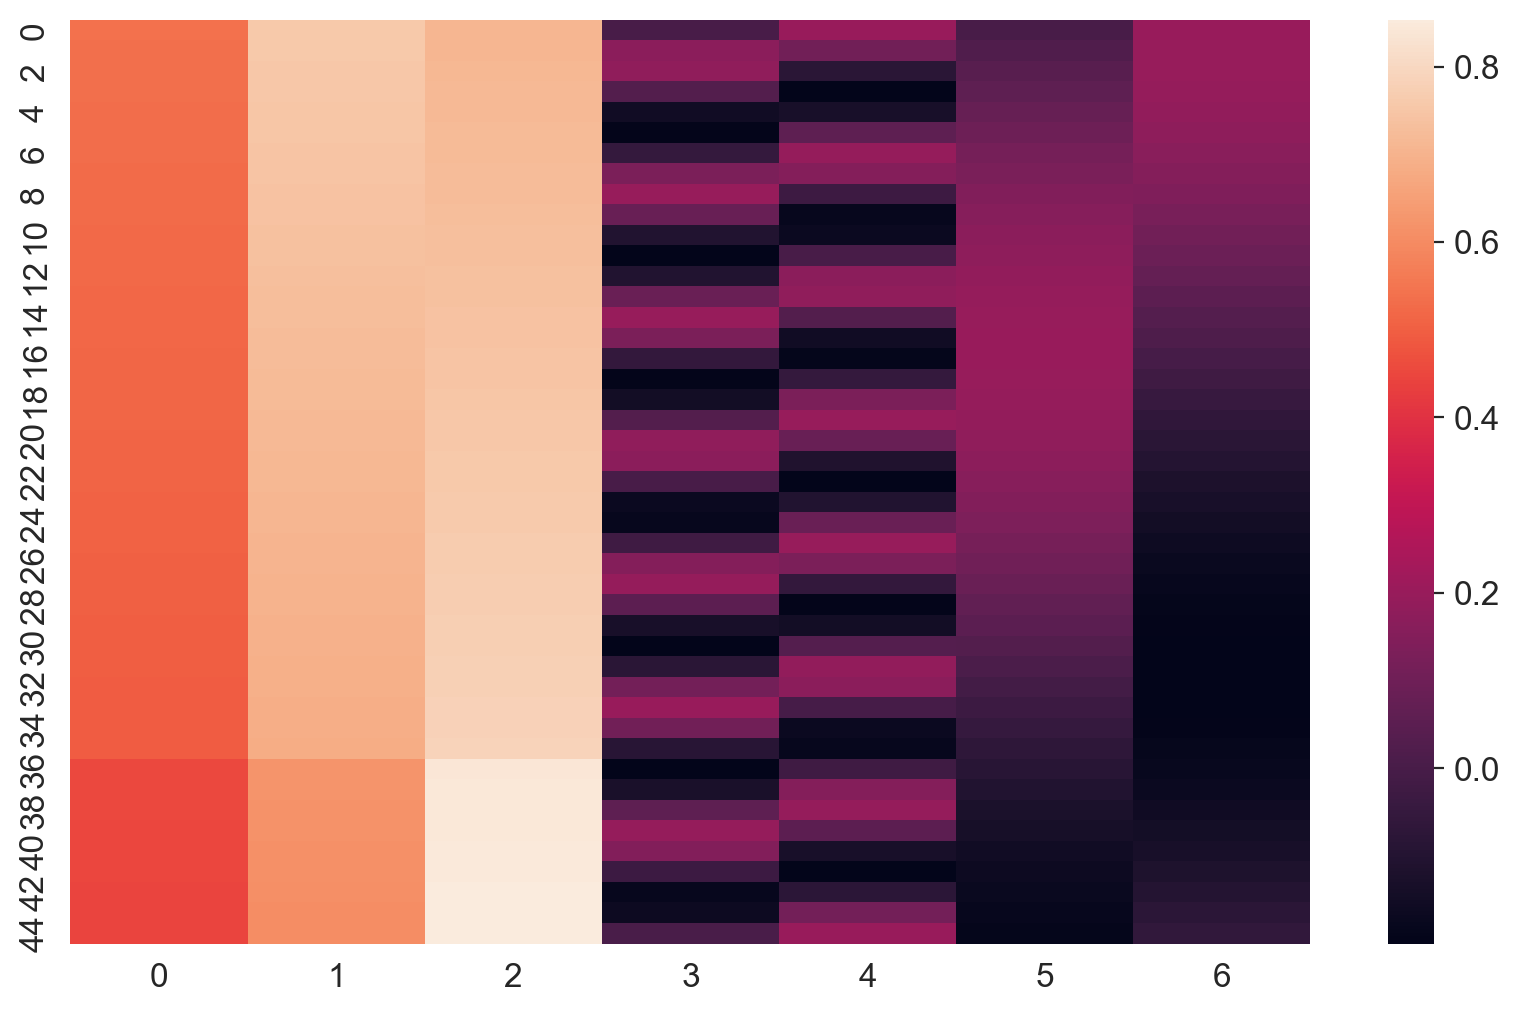

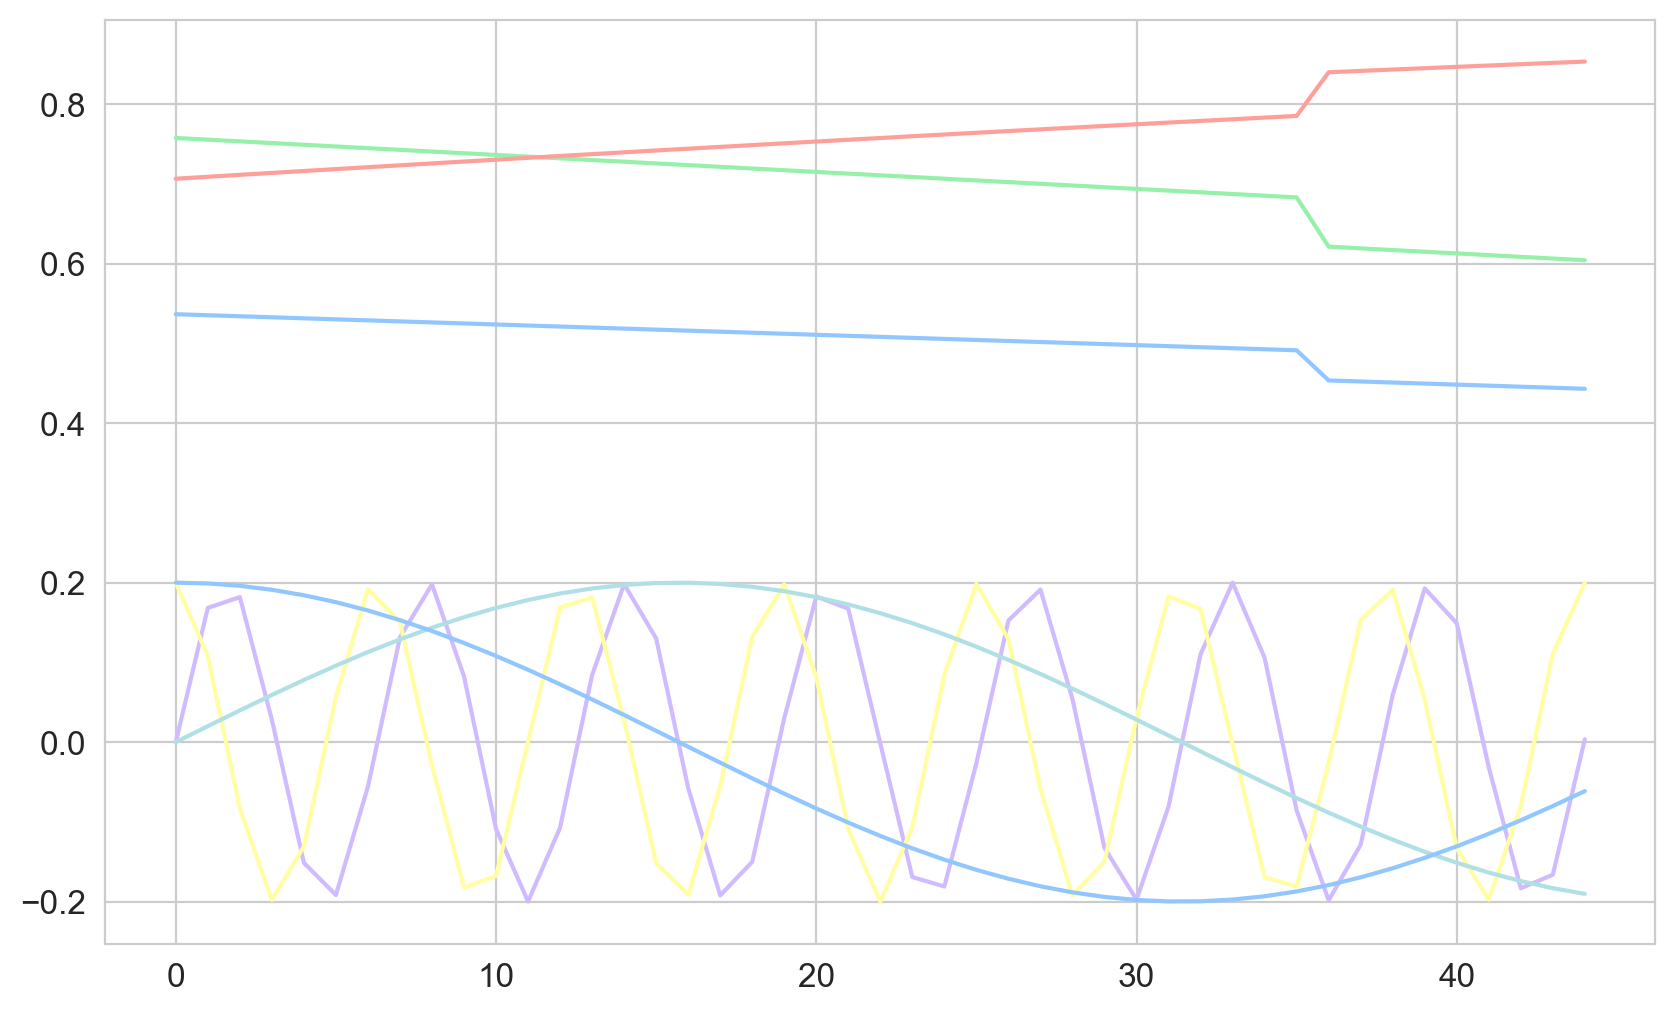

In [65]:
# Checking encondings with incomplete batch
# that requires padding
# Suggests positional encodings should be softened?

positional = PositionalEncoding(
    d_model=ENCODING_DIM, max_len=SAMPLES, dropout=0, device=DEVICE
)

iterator = iter(train_dataloader)
next(iterator)
next(iterator)
next(iterator)
next(iterator)
x, y = next(iterator)
after = positional(x[1:2].to(DEVICE))
after = after.cpu()

sns.heatmap(torch.squeeze(after))
plt.show()

plt.plot(after[0, :, :])
plt.show()

In [66]:
# Testing padding masks creation

print((np.isnan(x[:, :, 0]) == 1)[0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])


### Autoregressive mask

In [67]:
def create_autoregressive_sequence_mask(samples, min_uncovered=0):
    # Triangular matrix
    mask = torch.triu(torch.ones((samples, samples)), diagonal=1)
    # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float("-inf"))
    # Convert ones to 0
    mask = mask.masked_fill(mask == 0, float(0.0))
    mask[:, 0:min_uncovered] = 0
    return mask

In [68]:
SEQUENCE_MASK = create_autoregressive_sequence_mask(samples=SAMPLES).to(DEVICE)
SEQUENCE_MASK.shape, SEQUENCE_MASK[0]

(torch.Size([45, 45]),
 tensor([0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]))

### Special autoregressive mask that provides batch of initial samples

* Not used because it makes no sense with PyTorch nn.Transformer model

In [69]:
# SEQUENCE_MASK_MIN_VISIBLE = create_autoregressive_sequence_mask(
#     samples=SAMPLES, min_uncovered=MINSAMPLES - 1
# ).to(DEVICE)
# SEQUENCE_MASK_MIN_VISIBLE.shape, SEQUENCE_MASK_MIN_VISIBLE[0]

In [70]:
class TP_transformer(nn.Module):

    def __init__(
        self,
        num_positions=SAMPLES,
        encoding_layers=ENCODING_LAYERS,
        decoding_layers=DECODING_LAYERS,
        encoding_dim=ENCODING_DIM,
        embedding_dim=EMBEDDING_DIM,
        heads=HEADS,
        dropout_positional=0.1,
        dropout_transformer=0.1,
        device=DEVICE,
    ):
        super().__init__()
        self.num_positions = num_positions
        self.positional_encoder = PositionalEncoding(
            d_model=encoding_dim,
            max_len=num_positions,
            dropout=dropout_positional,
        )
        self.transformer = nn.Transformer(
            d_model=embedding_dim + encoding_dim,
            nhead=heads,
            num_encoder_layers=encoding_layers,
            num_decoder_layers=decoding_layers,
            dim_feedforward=num_positions,
            dropout=dropout_transformer,
            activation="relu",
            batch_first=True,  # Consistent with modified PositionalEncoding
            device=device,
        )
        self.linear = nn.Linear(in_features=7, out_features=3)

    def forward(self, X, Y, tgt_mask, src_pad_mask, tgt_pad_mask):

        xp = self.positional_encoder(X)
        yp = self.positional_encoder(Y)

        z = self.transformer(
            src=xp,
            tgt=yp,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask,
        )

        z = self.linear(z)
        return z


model = TP_transformer()
model.to(DEVICE)

TP_transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
          )
          (linear1): Linear(in_features=7, out_features=45, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=45, out_features=7, bias=True)
          (norm1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (

In [71]:
# Making padding masks and
# testing a batch

tp = TP_transformer(num_positions=SAMPLES, device=DEVICE)
X, Y = next(iterator)

M = torch.isnan(X[:, :, 0]) == 1  # True where NaNs
M = M.to(DEVICE)
X = torch.nan_to_num(X).to(DEVICE)
Y = torch.nan_to_num(Y).to(DEVICE)

O = tp(X, Y, SEQUENCE_MASK, M, M)
O, M.sum()

(tensor([[[ 1.5004,  0.0203,  0.0959],
          [ 1.3436, -0.1922,  0.1416],
          [ 1.2946, -0.5332, -0.3616],
          ...,
          [ 1.3731, -0.4279, -0.1850],
          [ 1.4725, -0.1274,  0.0050],
          [ 1.5475, -0.6206, -0.3614]],
 
         [[ 1.2584, -0.2655,  0.3271],
          [ 1.4018, -0.6266, -0.3908],
          [ 1.5037,  0.0403,  0.1588],
          ...,
          [ 1.4640, -0.1408,  0.1172],
          [ 1.2623, -0.0314,  0.0185],
          [ 1.4090,  0.1577,  0.1802]],
 
         [[ 1.3557,  0.1299,  0.2734],
          [ 1.3948, -0.3366, -0.1913],
          [ 1.6145, -0.5417, -0.6344],
          ...,
          [ 1.4923, -0.6375, -0.4062],
          [ 1.5629,  0.0235,  0.0349],
          [ 1.3072, -0.1706,  0.2193]],
 
         ...,
 
         [[ 1.3295, -0.1410, -0.4418],
          [ 1.1824, -0.6872, -0.0785],
          [ 1.5051,  0.2276, -0.0114],
          ...,
          [ 1.3011, -0.2385,  0.1281],
          [ 1.5254, -0.2629, -0.0386],
          [ 1.3906

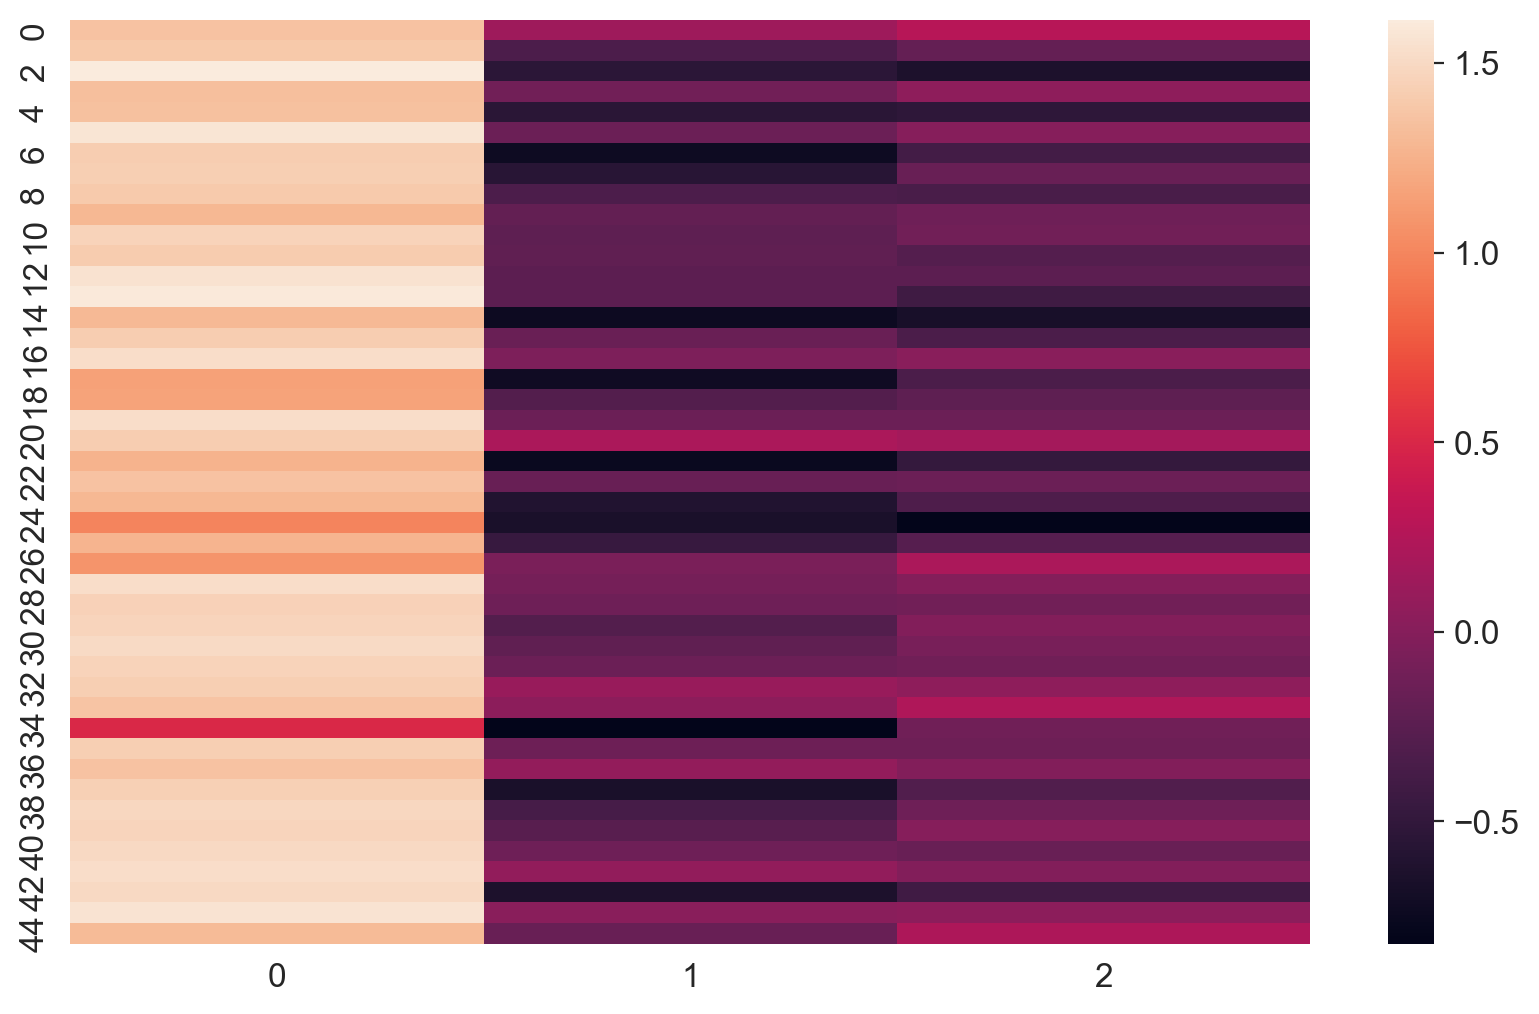

In [72]:
sns.heatmap(torch.squeeze(O[2]).cpu().detach().numpy())
plt.show()

Verifying if loss function requires transformation

In [73]:
# This means I can use MSELoss without issues
# as results when NaNs are present are the same

loss = nn.MSELoss()(O.to(DEVICE), Y)
trues = M.sum()

M.to(DEVICE)
MO = torch.masked_select(O, ~M[:, :, None]).to(DEVICE)
MY = torch.masked_select(Y, ~M[:, :, None]).to(DEVICE)
filtered_loss = nn.MSELoss()(MO, MY)

O.shape, Y.shape, M[:, :, None].shape, loss, trues, MO.shape, MY.shape, loss

(torch.Size([16, 45, 3]),
 torch.Size([16, 45, 3]),
 torch.Size([16, 45, 1]),
 tensor(0.8628, grad_fn=<MseLossBackward0>),
 tensor(89),
 torch.Size([1893]),
 torch.Size([1893]),
 tensor(0.8628, grad_fn=<MseLossBackward0>))

# Training the model

### Using MSELoss and Adam optimizer

Coded to only take into account the loss of the prediction embedding part and to ignore the NaNs

In [74]:
# Building model, optimizer, loss

model = TP_transformer(
    num_positions=SAMPLES,
    encoding_layers=ENCODING_LAYERS,
    decoding_layers=DECODING_LAYERS,
    encoding_dim=ENCODING_DIM,
    embedding_dim=EMBEDDING_DIM,
    dropout_positional=DROPOUT_POSITIONAL,
    dropout_transformer=DROPOUT_TRANSFORMER,
    heads=HEADS,
    device=DEVICE,
)

In [77]:
model.name = (
    f"tptrans{ENCODING_LAYERS}" + "drop"
    if DROPOUT_POSITIONAL > 0
    else "" + "lin"
)
model.name

'tptrans4drop'

In [78]:
LOAD_MODEL = False
LOAD_PATH = "save/tptrans4drop_2024-11-29_19-42"

if LOAD_MODEL:
    model.load_state_dict(torch.load(LOAD_PATH, weights_only=True))

In [79]:
# Global variables to allow interrupting the training

global_epoch_number = 1  # will keep the epoch number within runs
best_dev_loss = 1  # will keep record of best dev loss

In [81]:
# Loss and optimizer

LEARNING_RATE = 0.001  # initial 0.001, may go down to 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss = nn.MSELoss()

### Epoch Training loop function

In [82]:
def train_one_epoch(model, optimizer, loss_fn, epoch_index, writer, device):
    """
    Implementation of one epoch train
    """
    running_loss = 0.0
    last_loss = 0.0

    model.train()
    for i, data in enumerate(train_dataloader):  # could be iter()
        X, Y = data
        M = torch.isnan(X[:, :, 0]) == 1  # True where NaNs
        M = M.to(device)
        X = torch.nan_to_num(X).to(device)
        Y = torch.nan_to_num(Y).to(device)

        optimizer.zero_grad()
        O = model(
            X,  # src to encoder
            Y,  # tgt to decoder
            SEQUENCE_MASK,  # tgt autoregressive mask
            M,  # padding mask src
            M,  # padding mask tgt
        )
        loss = loss_fn(O, Y)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print(f"  batch {i + 1} loss: {round(last_loss,6)}")
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

### To test dev loss

In [85]:
def dataset_average_loss(model, dataloader, loss_fn, device):
    """
    Loss of a given set, to be used with dev or test
    """
    running_dev_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(dataloader):
            X, Y = vdata
            M = torch.isnan(X[:, :, 0]) == 1  # True where NaNs
            M = M.to(device)
            X = torch.nan_to_num(X).to(device)
            Y = torch.nan_to_num(Y).to(device)
            O = model(
                X,  # src to encoder
                Y,  # tgt to decoder
                SEQUENCE_MASK,  # tgt autoregressive mask
                M,  # padding mask src
                M,  # padding mask tgt
            )
            dev_loss = loss_fn(O, Y)
            running_dev_loss += dev_loss

    return float(running_dev_loss / (i + 1))

### Main Training Loop function

In [ ]:
def train_model(
    model,
    optimizer,
    loss_fn,
    epochs,
    writer,
    model_path,
    device,
):
    """
    Implements training loop
    """

    global global_epoch_number
    global best_dev_loss

    for _ in range(epochs):
        print(f"EPOCH {global_epoch_number}:")

        avg_train_loss = train_one_epoch(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epoch_index=global_epoch_number,
            writer=writer,
            device=device,
        )

        avg_dev_loss = dataset_average_loss(
            model=model,
            dataloader=dev_dataloader,
            loss_fn=loss_fn,
            device=device,
        )

        print(
            f"LOSS train {round(number=avg_train_loss,ndigits=6)}"
            + f" valid {round(number=avg_dev_loss,ndigits=6)}"
        )

        writer.add_scalars(
            "Training vs. Validation Loss",
            {
                "Training": avg_train_loss,
                "Validation": avg_dev_loss,
            },
            global_epoch_number + 1,
        )
        writer.add_scalars(
            "Learning Rate",
            {
                "LR": optimizer.param_groups[0]["lr"],
            },
            global_epoch_number + 1,
        )
        writer.flush()

        # Track best performance, and save the model's state
        if avg_dev_loss < best_dev_loss:
            best_dev_loss = avg_dev_loss
            torch.save(
                model.state_dict(), model_path + f"_{global_epoch_number}"
            )
            torch.save(model, model_path + f"_{global_epoch_number}.pt")

        global_epoch_number += 1

### Setting up Tensorboard run

In [87]:
# Only for new runs!
# Separated so the run can be extended manually, do not execute again on same run
#
# Already used:
# * tptrans3drop: 3transformer layers and dropoff
# * tptrans3: 3 transformer layers


timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
writer = SummaryWriter(f"runs/{model.name}_{timestamp}")
model_path = f"save/{model.name}_{timestamp}"

## Training execution



In [88]:
train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss,
    epochs=10,
    writer=writer,
    model_path=model_path,
    device=DEVICE,
)

EPOCH 1:
  batch 1000 loss: 0.003003
  batch 2000 loss: 0.000435
  batch 3000 loss: 0.000296
  batch 4000 loss: 0.00025
  batch 5000 loss: 0.000227
  batch 6000 loss: 0.000245
  batch 7000 loss: 0.000213
  batch 8000 loss: 0.000173
  batch 9000 loss: 0.000214
  batch 10000 loss: 0.000337
  batch 11000 loss: 0.00023
  batch 12000 loss: 0.000178
  batch 13000 loss: 0.000171
  batch 14000 loss: 0.000165
  batch 15000 loss: 0.000243
  batch 16000 loss: 0.000219
  batch 17000 loss: 0.000188
  batch 18000 loss: 0.000221
  batch 19000 loss: 0.000177
  batch 20000 loss: 0.000165
  batch 21000 loss: 0.000152
  batch 22000 loss: 0.000146
  batch 23000 loss: 0.000232
  batch 24000 loss: 0.00015
  batch 25000 loss: 0.000166
  batch 26000 loss: 0.000185
  batch 27000 loss: 0.000157
  batch 28000 loss: 0.000168
  batch 29000 loss: 0.000141
  batch 30000 loss: 0.000198
  batch 31000 loss: 0.000151
  batch 32000 loss: 0.000151
  batch 33000 loss: 0.000162
  batch 34000 loss: 0.000179
  batch 35000 los

KeyboardInterrupt: 

## Training and dev accuracy progression

In [96]:
#
# tptrans3drop: 3transformer layers and dropoff
# tptrans3: 3 transformer layers


def show_train_dev(filetrain, filedev, delta=None):
    history1 = pd.read_csv(filetrain)
    history2 = pd.read_csv(filedev)

    if delta:
        history1["Step"] = history1["Step"] - delta
        history2["Step"] = history2["Step"] - delta

    hist = (
        history1.set_index("Step")
        .join(
            history2.set_index("Step"),
            rsuffix=" validation",
            lsuffix=" training",
        )
        .drop(["Wall time training", "Wall time validation"], axis=1)
    )
    hist["Value validation"] = hist["Value validation"].interpolate(
        method="linear"
    )
    hist.plot()
    plt.ylim((0, 0.003))
    plt.xlim((0, 300000))
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.show()

### 3-layer transformer model with dropoff

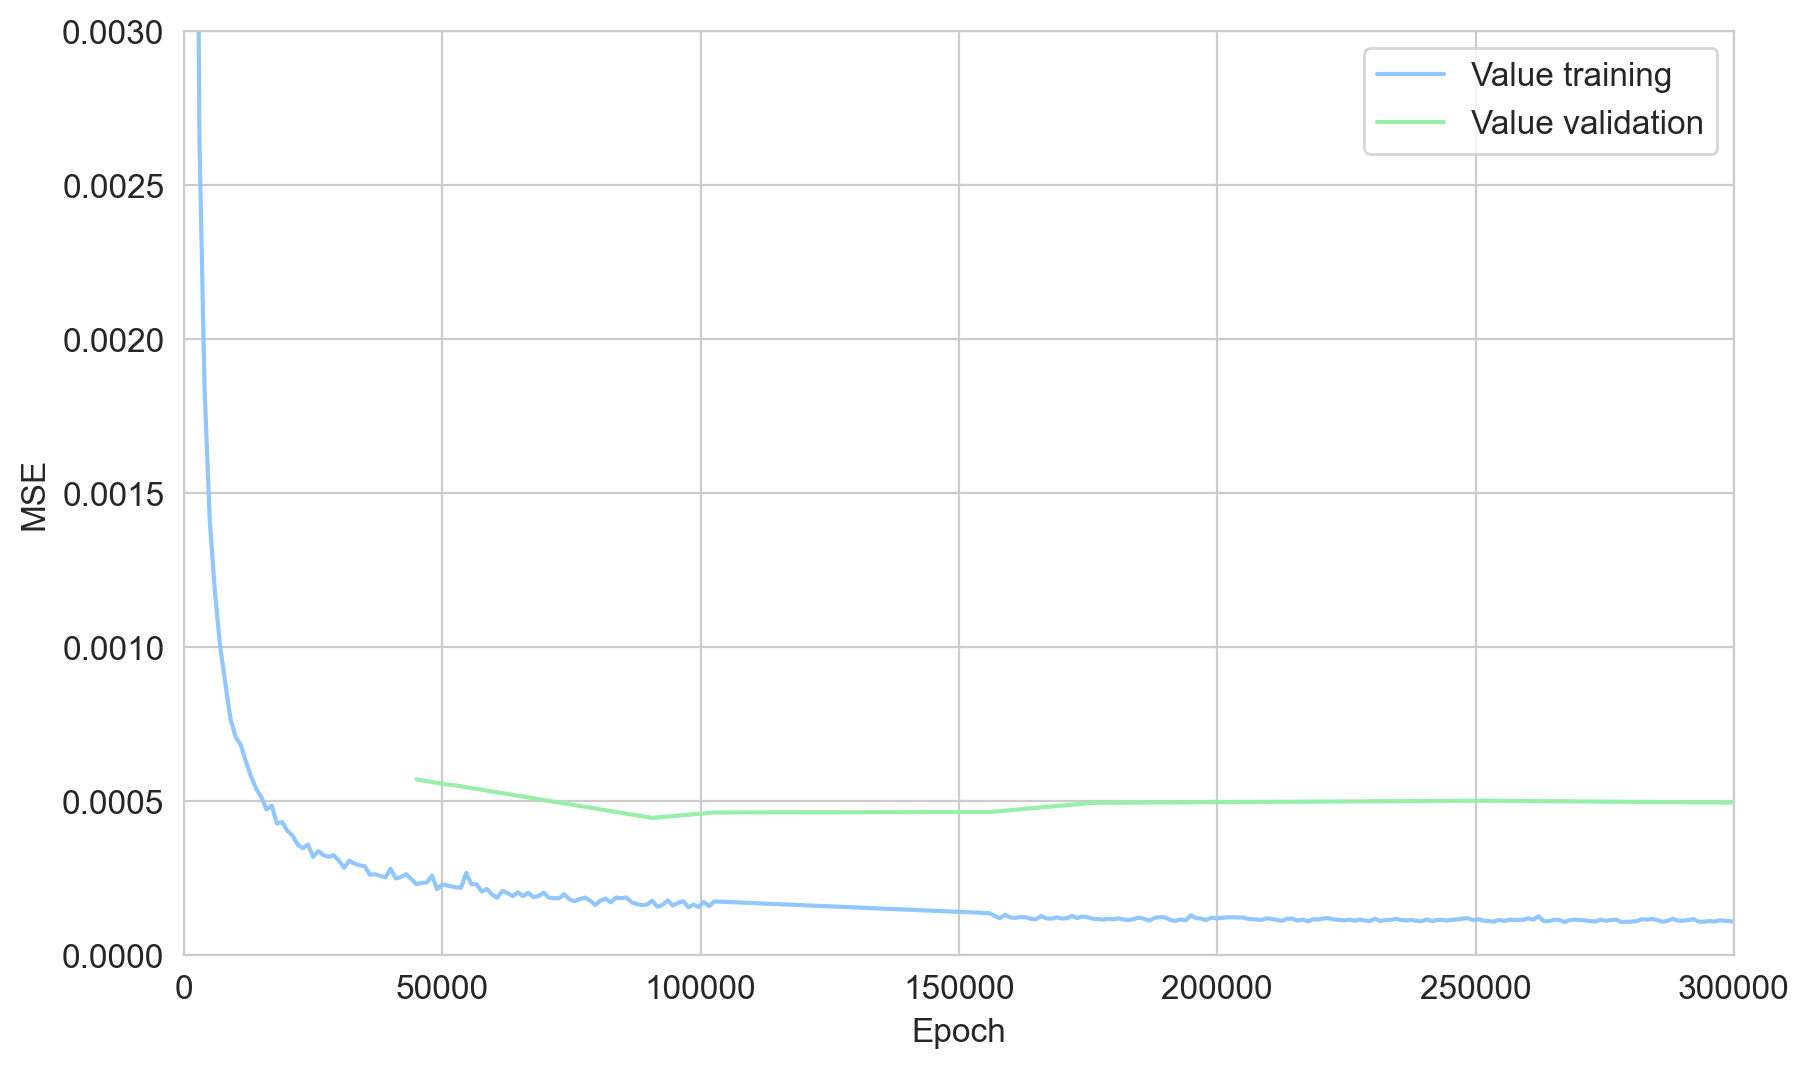

In [97]:
show_train_dev(
    "logs/tptrans3drop_training.csv",
    "logs/tptrans3drop_validation.csv",
)

### 3-layer transformer model without drop-off

* Quick overfitting, generalisation suffers

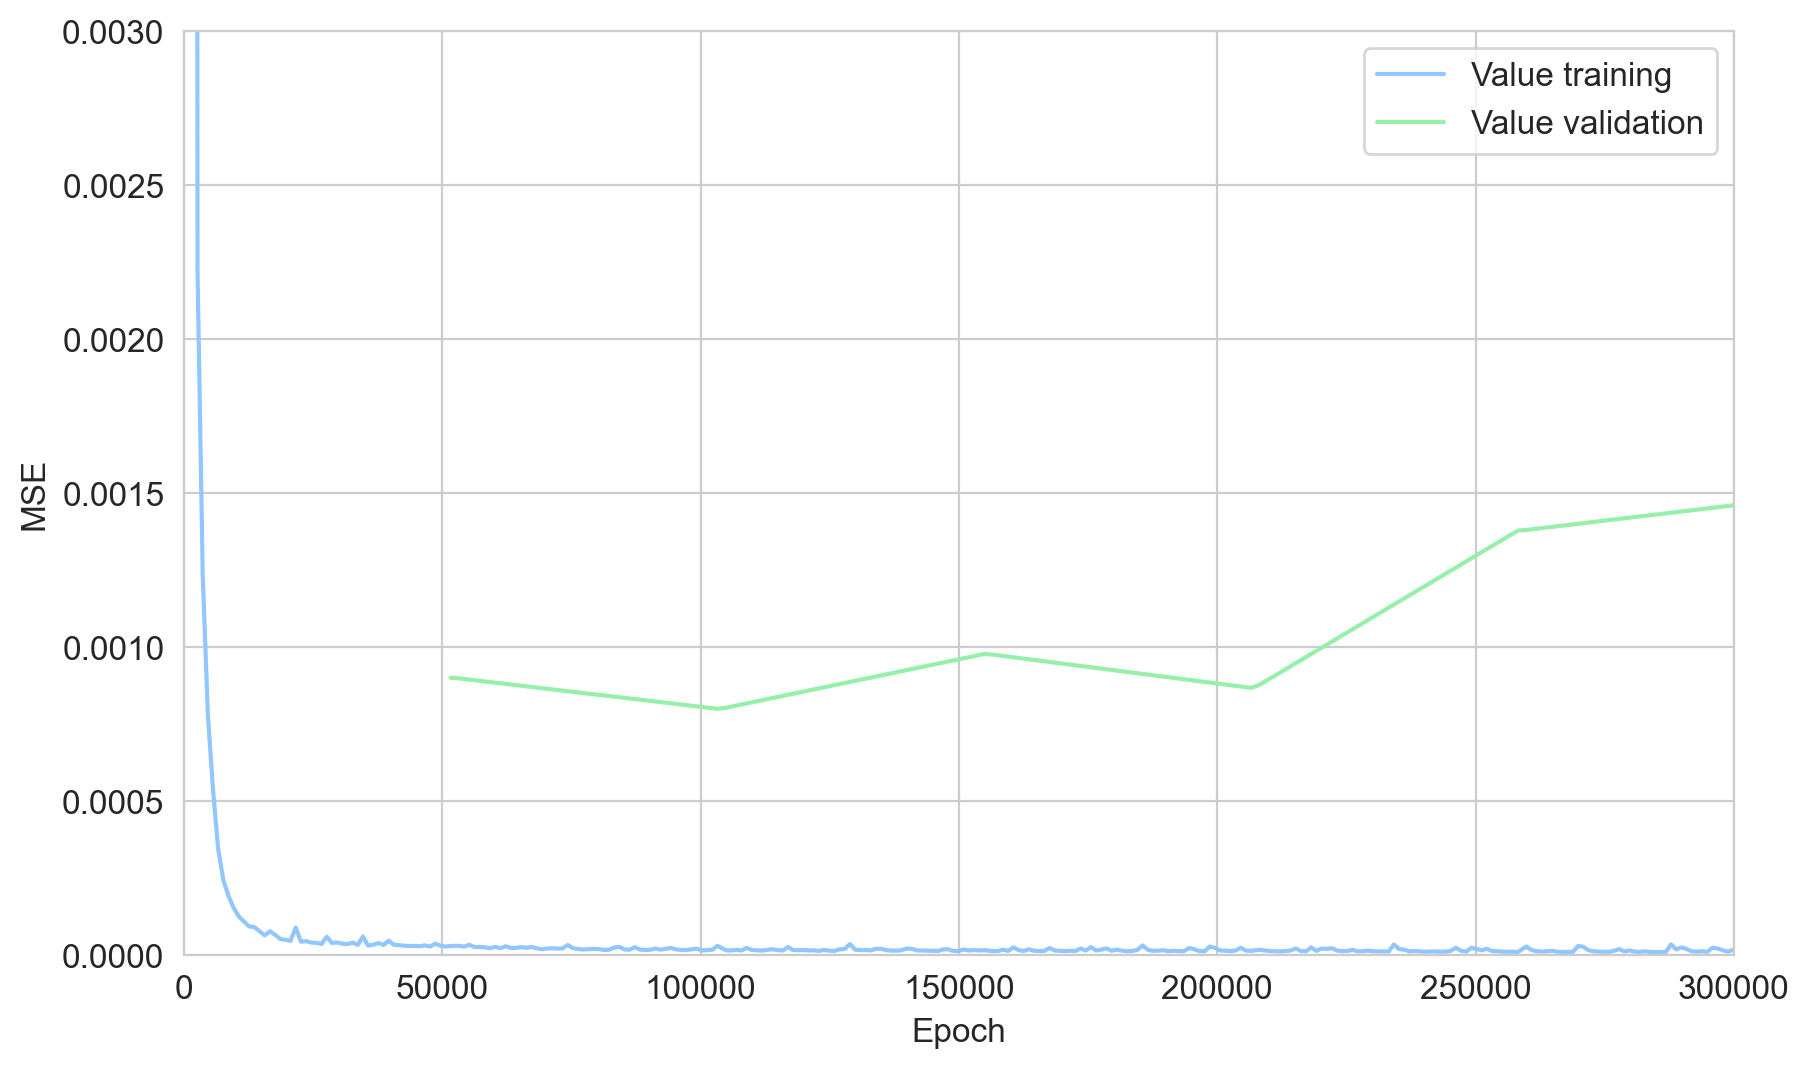

In [98]:
show_train_dev(
    "logs/tptrans3_training.csv",
    "logs/tptrans3_validation.csv",
    delta=51000,
)

### 4-layer transformer model with drop-off

* Quick overfitting, generalisation suffers

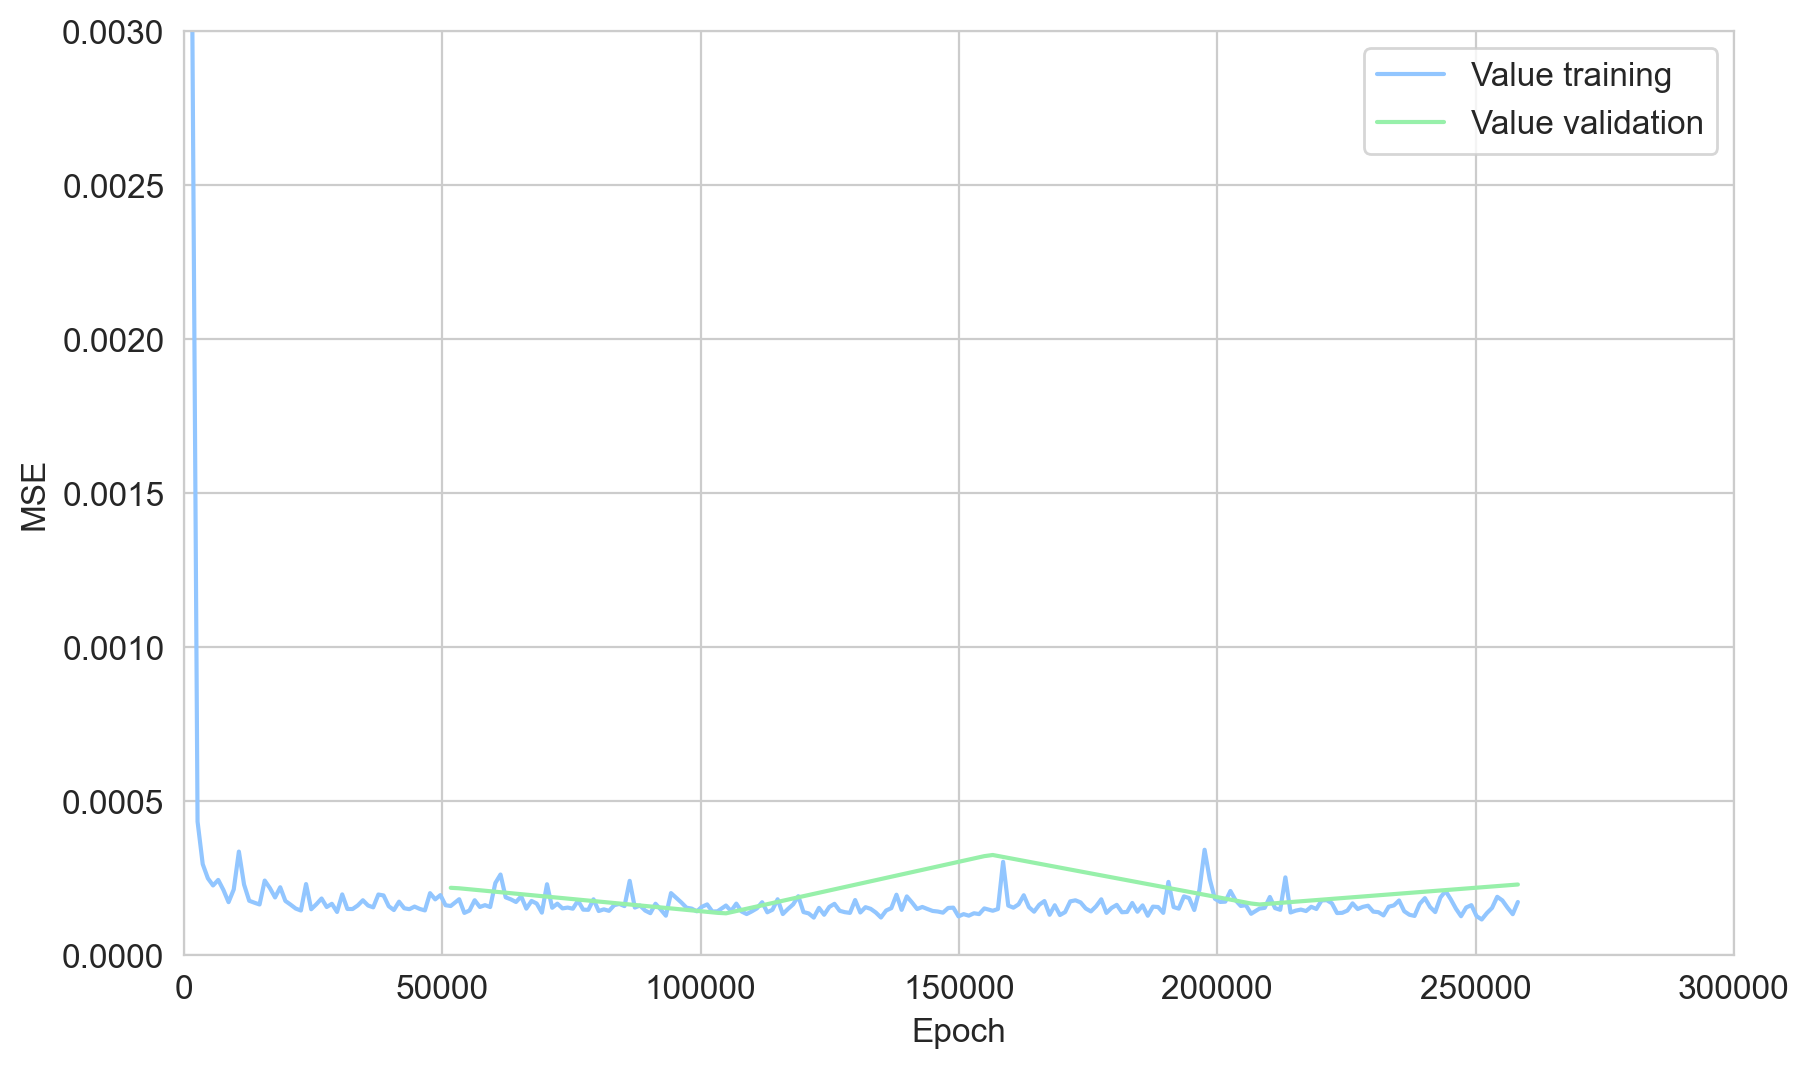

In [99]:
show_train_dev(
    "logs/tptrans4drop_training.csv",
    "logs/tptrans4drop_validation.csv",
    delta=51000,
)

# Flight trajectory prediction using the model

In [ ]:
def predict(
    model,
    match,
    point,
    minlength,
    length,
    device=DEVICE,
    bootstrap=True,
    dummy_predict=False,
):
    """
    Prediction function

    Bootstrap takes a minlength tracks as prediction start
    If dummy predict then returns the input (no model)
    """

    unix = match.iloc[point : point + length]["Unix"].to_numpy()

    X = torch.tensor(
        match.iloc[point : point + length][
            ["Prj_E_norm", "Prj_N_norm", "Prj_U_norm"]
        ].to_numpy()[None, :, :],
        dtype=torch.float,
    ).to(
        device
    )  # FPL projected

    if X.shape[1] == length:

        if dummy_predict:
            return X[0], unix
        else:
            Y = torch.tensor(
                match.iloc[point : point + length][
                    ["Trk_E_norm", "Trk_N_norm", "Trk_U_norm"]
                ].to_numpy()[None, :, :],
                dtype=torch.float,
            ).to(device)
            # Track

            result = torch.tensor(
                np.zeros_like(Y),
                dtype=torch.float,
            ).to(device)

            if bootstrap:
                result[0, :minlength] = Y[0, :minlength]
                startpoint = minlength
            else:
                result[0, 0] = Y[0, 0]
                startpoint = 0

            model.eval()
            with torch.no_grad():
                for i in range(startpoint, length):
                    mask = torch.tensor(
                        (np.linspace(0, length - 1, length) > i)[None, :]
                    ).to(device)
                    pred = model(X, result, None, None, mask)
                    result[0, i] = pred[0, i]

            return result[0], unix
    else:
        return None

### Select random flight from the test set

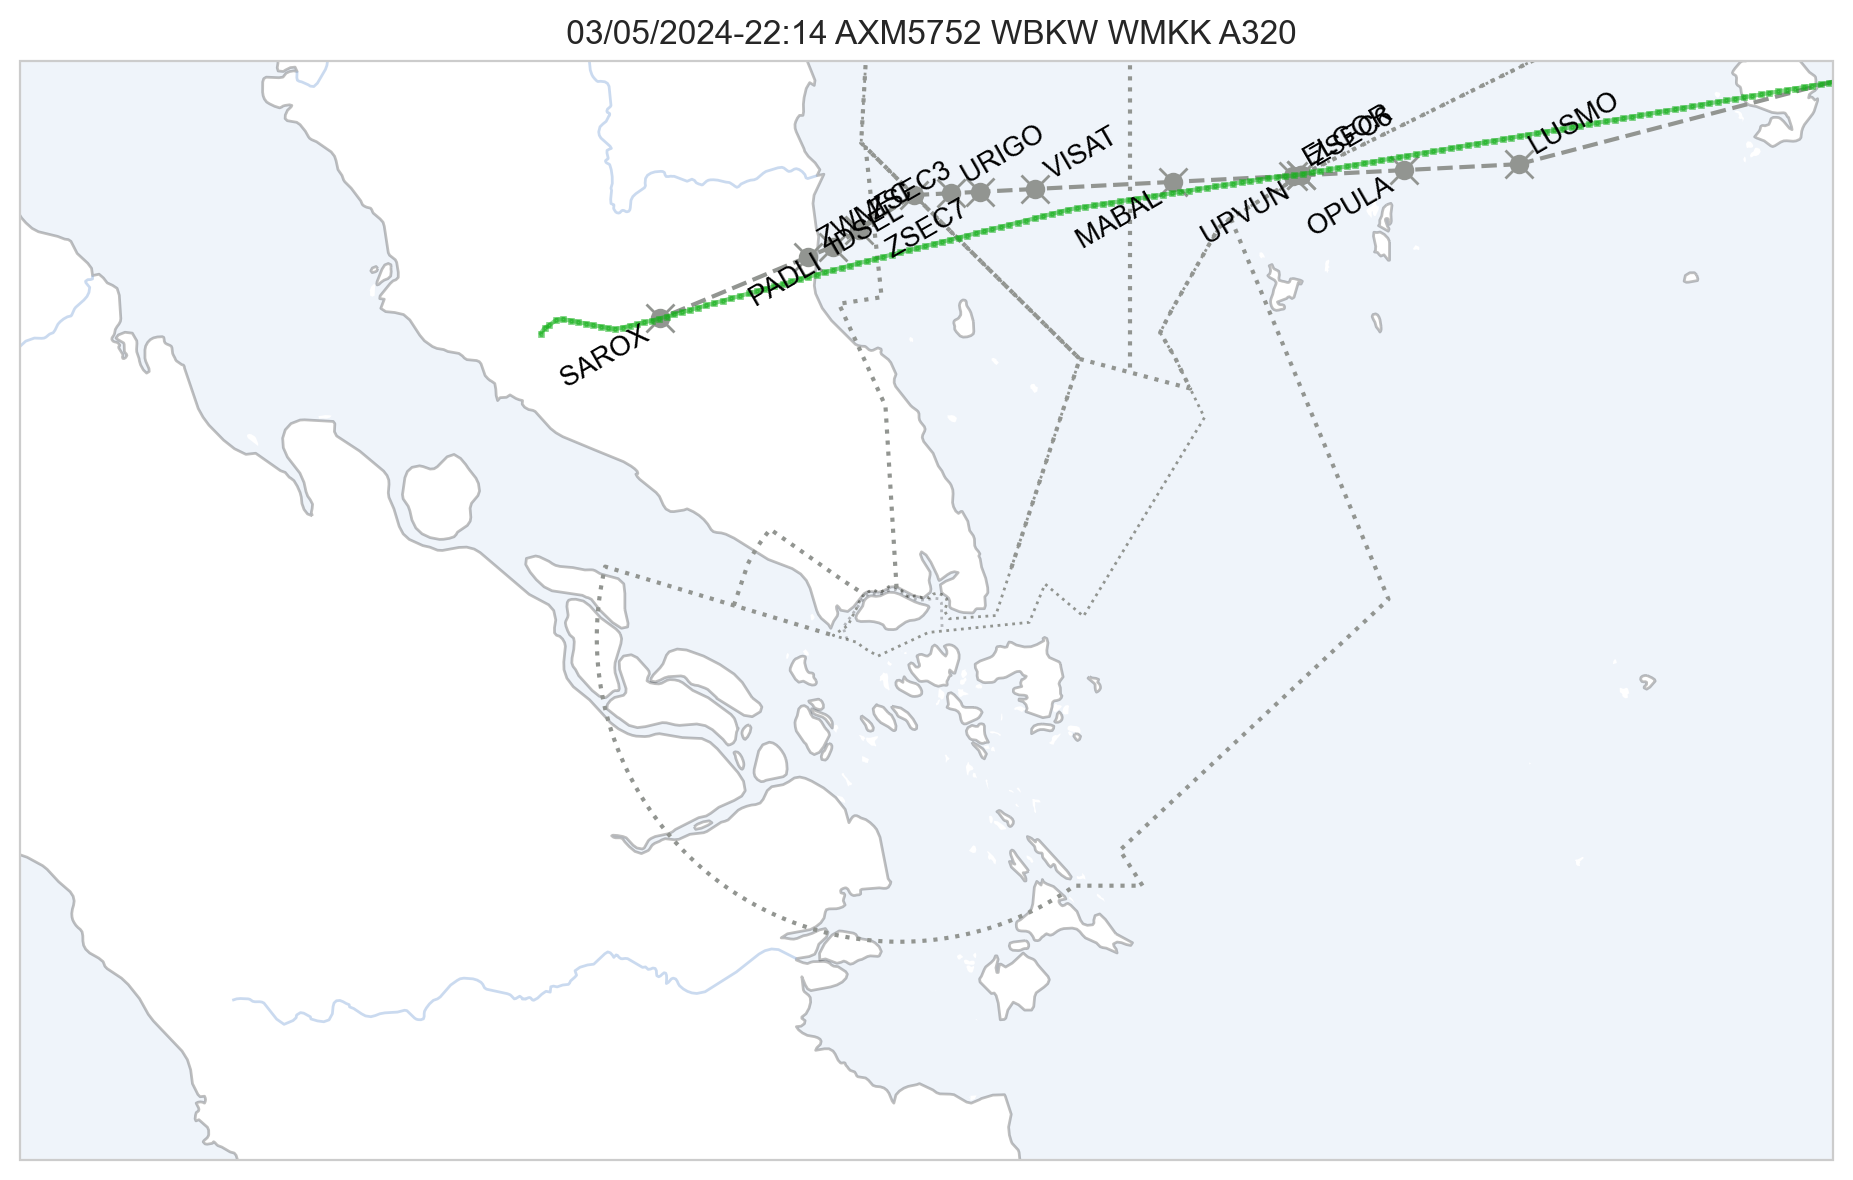

In [206]:
flight: Fl = random.choice(test.flights)
flight.plot(ratio=0.6, wide=500)

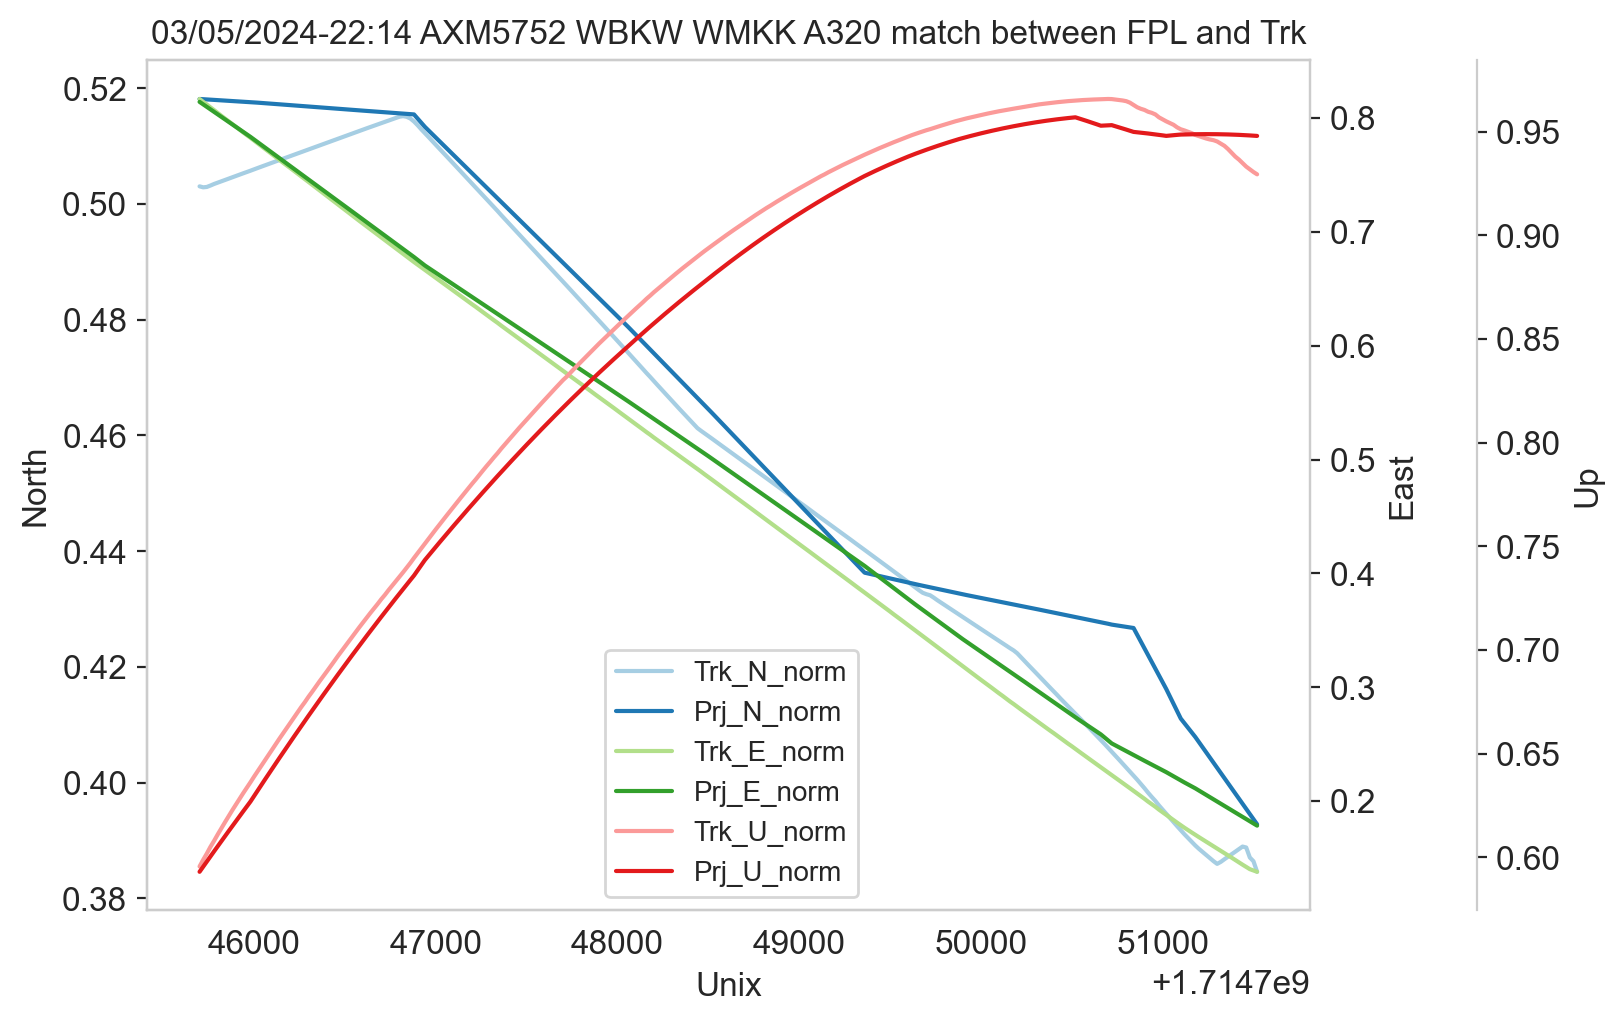

In [207]:
flight.full_match_to_enu_transform(TRANSFORMATION).plot_match(
    geo=False, norm=True
)

In [210]:
predictions = [
    predict(
        model=model,
        match=flight.match,
        point=p * 40,
        minlength=MINSAMPLES - 1,
        length=SAMPLES,
    )
    for p in range(6)
]

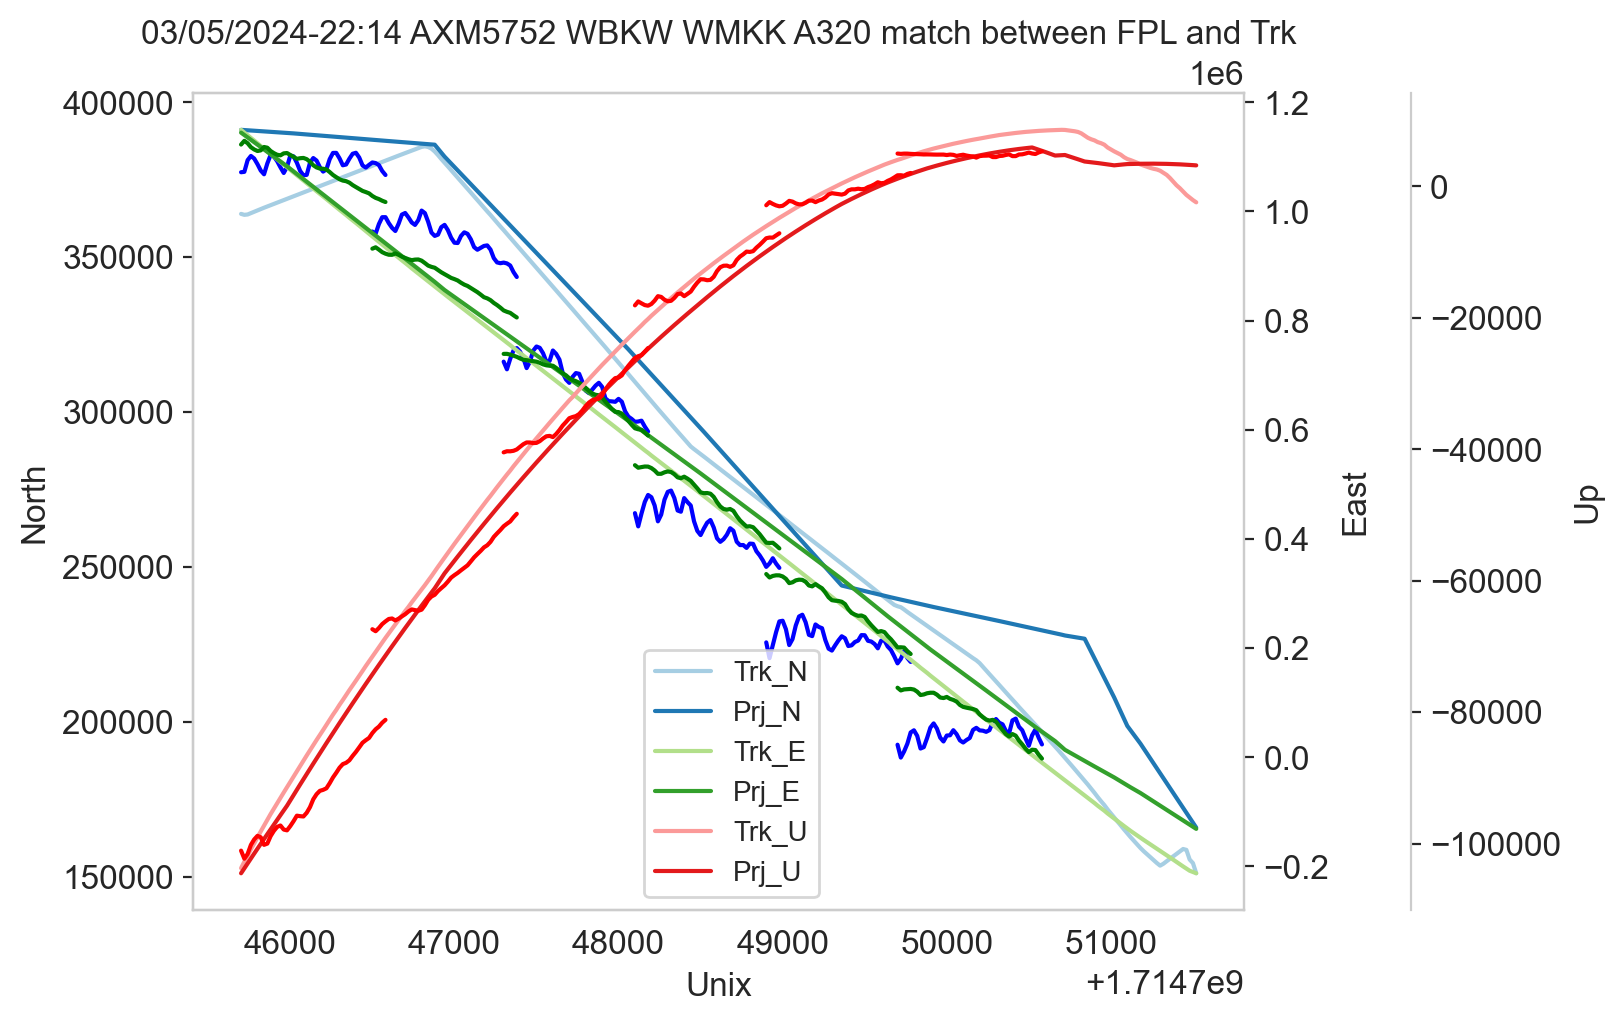

In [211]:
flight.plot_match(geo=False, norm=False, additional=predictions)

## Looking at the accuracy measurement

In [ ]:
def measure_accuracy(model, data_set, samples, dummy_predict=False):
    """
    Creates a set of predictions and compares predictions with tracks
    every minute to assess error in euclidean distance
    """
    buckets = {
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: [],
        10: [],
        11: [],
        12: [],
        13: [],
        14: [],
    }
    for _ in range(samples):
        flight = random.choice(data_set.flights)
        if len(flight.match) - 50 > 0:
            point = random.randint(0, len(flight.match) - 50)
            pred, unix = predict(
                model=model,
                match=flight.match,
                point=point,
                minlength=MINSAMPLES - 1,
                length=SAMPLES,
                dummy_predict=dummy_predict,
            )
            for bucket_num in range(1, 15):
                buckets[bucket_num].append(
                    math.sqrt(
                        (
                            pred[3 * bucket_num, 0]
                            - flight.match.iloc[point + 3 * bucket_num][
                                "Trk_E"
                            ]
                        )
                        ** 2
                        + (
                            pred[3 * bucket_num, 1]
                            - flight.match.iloc[point + 3 * bucket_num][
                                "Trk_N"
                            ]
                        )
                        ** 2
                    )
                    * Fl.METER_2_NM
                )

    return pd.DataFrame(
        {
            "1m": buckets[1],
            "2m": buckets[2],
            "3m": buckets[3],
            "4m": buckets[4],
            "5m": buckets[5],
            "6m": buckets[6],
            "7m": buckets[7],
            "8m": buckets[8],
            "9m": buckets[9],
            "10m": buckets[10],
            "11m": buckets[11],
            "12m": buckets[12],
            "13m": buckets[13],
            "14m": buckets[14],
        }
    )

In [214]:
def error_boxplot(buckets, name):
    """
    Renders boxplot of a model given a set
    of error samples, longitudinal and lateral
    """
    plt.figure()

    buckets.boxplot(
        column=[
            "1m",
            "2m",
            "3m",
            "4m",
            "5m",
            "6m",
            "7m",
            "8m",
            "9m",
            "10m",
            "11m",
            "12m",
            "13m",
            "14m",
        ],
        rot=45,
    )
    plt.xlabel("Minutes")
    plt.ylabel("Error (NM)")
    plt.title(f"TP Model: {name}", fontsize=16)

## Accuracy of the model

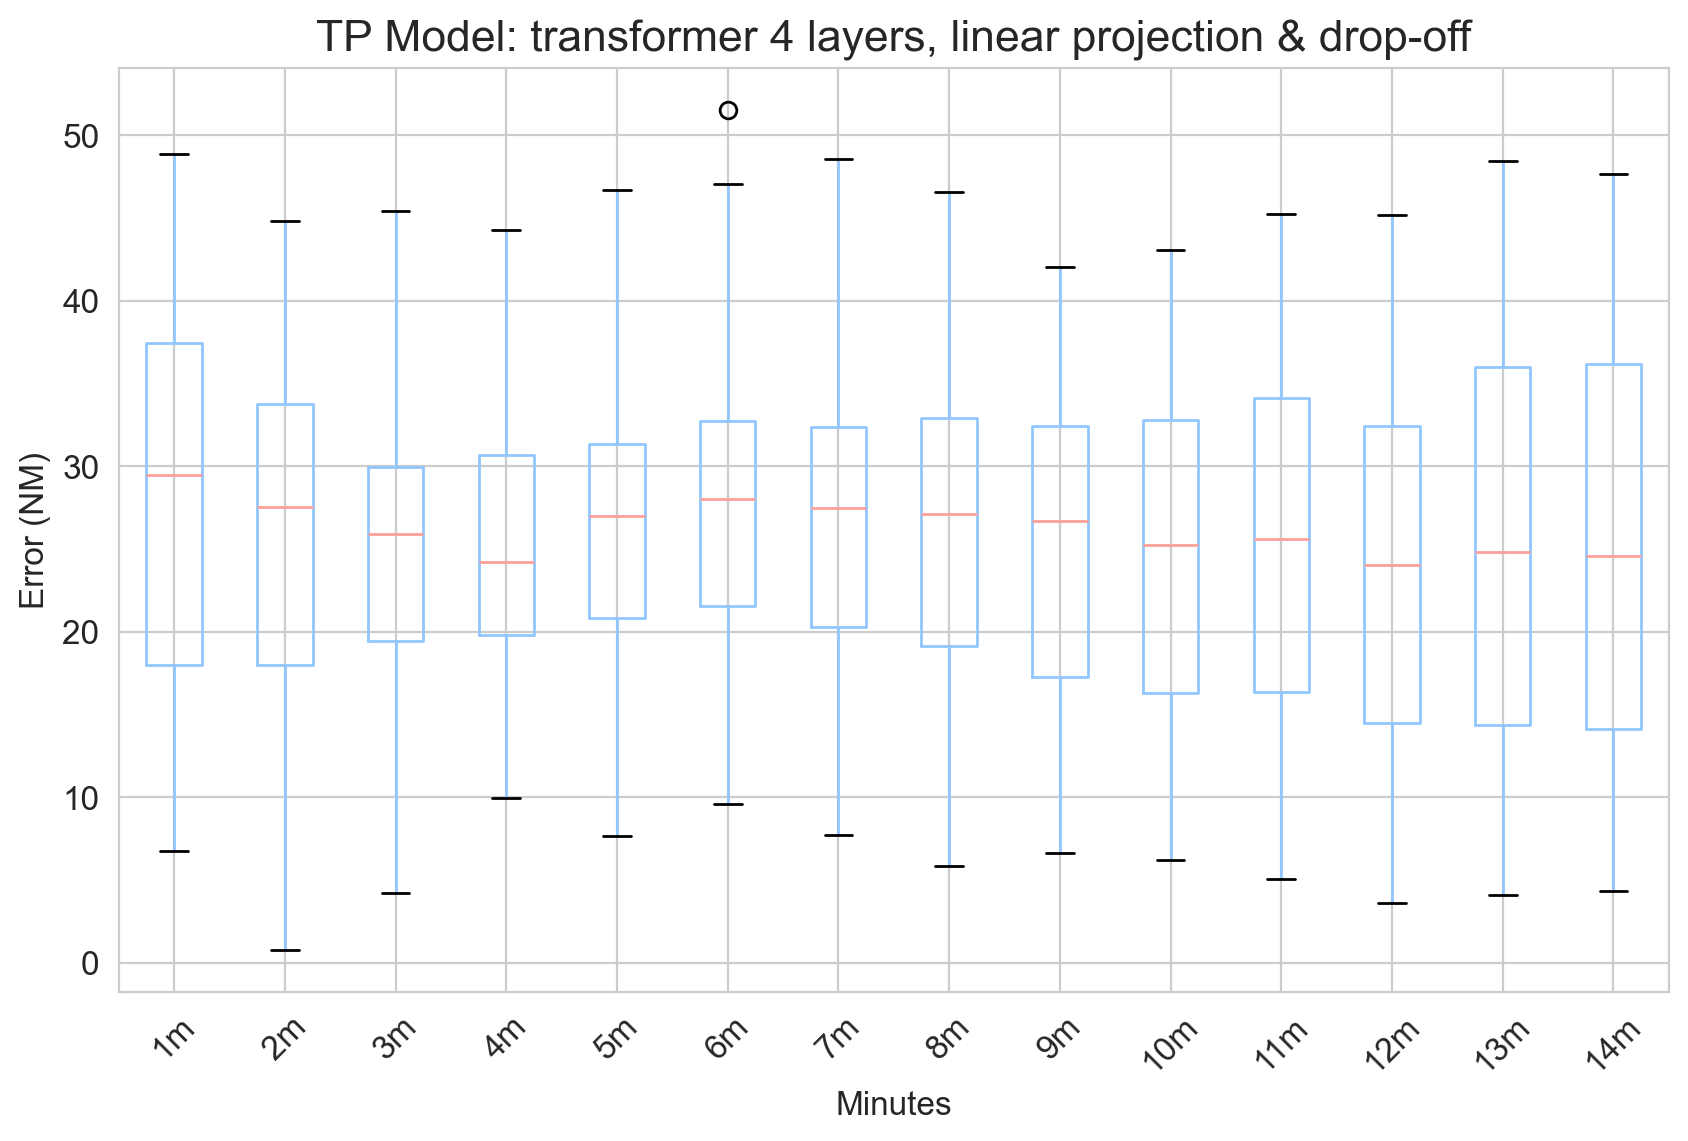

In [ ]:
buckets = measure_accuracy(model, test, 50)
error_boxplot(buckets, "transformer 4 layers, linear projection & drop-off")

## Accuracy without model

In [ ]:
buckets = measure_accuracy(model, test, 50, dummy_predict=True)
error_boxplot(buckets, "Accuracy of no-model (projections in place of tracks)")